# NYU-CUSP Principles of Urban Informatics 2017 final

### Completed by Anonymous


<img src="01_Anonymous_Image.jpg" alt="title" style="width: 200px; float: left;" />

#### Adapted from instructions notebook provided by fbb

# Abstract

The are many factors which contribute to the incidence of crime. Governments and organizations around the world are interested in these factors, as they may use it to make decisions about law enforcement resources or promoting initiatives which address these factors and subsequently reduce crime.

The topic of this research is to explore if the factors Median Income, Unemployment and access to Green spaces are related to crime. The subject area of our study is the policing precincts on New York City. The New York Police Department (NYPD) publish statistics about crime by policing precinct, including historical time series tracking occurence of the seven (7) major felonies by type and precinct over time since 2000.

This analysis assesses patterns in these crime indicators. We seek to cluster patterns from the time series and assess if the crime indicators exhibit both spatial and temporal patterns. We found after reviewing the time series, precincts could be classified as a particular type. The types were either:
     1. Consistently and gradually decreasing,
     2. Aggresively decreasing with a hump in recent years, 
     3. Gradually decreasing with a hump in recent years, or
     4. Volatile - bouncing around with many local minima / maxima.

These clustered time series also exhibited non-random patterns in the spatial dimension. i.e. if one precinct exhibited a particular trend in their time series; neighbouring precincts would exhibit similar patterns in theirs also.

We performed a clustering analysis of the socio-economic factors to assess patterns of this geographically in New York City. We performed another clustering analysis including the crime statistics also to observe how socio-economic, demographic and neighborhood features such as parks would impact crime rates. 

There were observed patterns and relationships between crime and socio-economic attributes of precincts and we modelled this using a regression fit technique. We also found differences in the type of crime observed in different neighbourhoods. For example, murder was more likely to occur in precincts with lower median income. Compared with Grand Larceny of a Motor Vehicle - which was more likely to occur in precincts with higher median income. We would need to undertake further analysis of this to deduce causation, but it may be because higher income precincts have more expensive and better cars, and therefore are more likely to attract motor theft.

Finally, we fitted a multiple linear regression model to estimate each of the seven (7) different crime types, using regressors for Median Income, Green Area and Unemployment by precinct. We concluded that income was the most significant variable to estimate each of the individual crime types by precinct; but at an aggregate level (i.e. total of the seven (7) crime by precinct), **Green area** was the most significant regressor.

## We conclude that parks and green spaces are a significant factor with respect to crime.


__________________________________________________________





**Motivation: (as included by fbb)**

The study of NYC crime is of broad interest in the Urban Science scene, and NYPD has provided statistics on the crime (by precinct) for several years. This is an important resource to understand and analyze urban crime. There are obvious connections between crime and wealth, which relate both to access to precious goods (opportunity), and to how easy it is to commit a crime (the neighborhood safety, or perceived safety). [It has been suggested](https://journalistsresource.org/studies/government/criminal-justice/unemployment-property-crime-burglary) that unemployment correlates strongly with burglary for example, due to both opportunity and motivation. In addition there are [several pieces of research](https://www.citylab.com/solutions/2016/04/vacant-lots-green-space-crime-research-statistics/476040/) that indicate that access to green spaces affects crime.

#### The usual imports

In [1]:
#Usual packages for import

from __future__ import print_function, division
import pylab as pl
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn.clusterEC
from scipy.cluster.vq import whiten

from scipy import cluster
from geopy.distance import great_circle
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp

from scipy.spatial.distance import cdist, pdist

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans2


# url handlers

import ast
import urllib.request
from io import StringIO
import os
import zipfile

try:
    #Packages for Python 3
    from urllib.parse import urlencode
    from urllib.request import urlopen
    from urllib.error import HTTPError
    
except ImportError:
    #Packages for Python 2
    from urllib import urlencode
    from urllib2 import urlopen, HTTPError
    
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from geopy.geocoders import Nominatim
import geopandas as gp

import scipy.stats
import seaborn as sns
import statsmodels.api as sm
plt.style.use('seaborn')

%pylab inline

## additional imports (although I'm not sure I ended up using them)
import choroplethNYC as cp
import categoricalcolorbar as ccb


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


# Geographical data load

Before undertaking the analysis, it is helpful to understand and visualize which geographical areas we are interested in for the purposes of tracking and assessing crime. We download the Police Precinct shp files and plot a choropleth of the New York City police precincts.


In [2]:

filename = 'nypp_17d.zip'

#get file from website
!wget http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypp_17d.zip

os.system("mv " + filename + " " + os.getenv("PUIDATA")) #moves file to PUIDATA directory


--2017-12-17 21:27:29--  http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypp_17d.zip
Resolving www1.nyc.gov... 104.106.240.221, 2600:141b:13:297::1500, 2600:141b:13:292::1500
Connecting to www1.nyc.gov|104.106.240.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789057 (771K) [application/zip]
Saving to: “nypp_17d.zip”

100%[======================================>] 789,057     3.02M/s   in 0.2s    

2017-12-17 21:27:29 (3.02 MB/s) - “nypp_17d.zip” saved [789057/789057]



0

In [3]:
#Unzip and put into PolicePrecData
os.system("unzip " + os.getenv("PUIDATA") + "/" + filename + " -d " + os.getenv("PUIDATA") + "/PolicePrecData")



256

### Create geodataframe from shapefile

In [4]:
files = os.listdir(os.getenv("PUIDATA") + "/PolicePrecData")
shpfile = [x for x in files if 'shp' in x]

In [5]:
shpfile[0]

'geo_export_e39489fd-260c-43b3-a84c-5b5a7f534af0.shp'

In [6]:
policePreshp = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/PolicePrecData" + "/" + shpfile[0])

In [7]:
policePreshp.head()

precinct    shape_leng    shape_area  \
0       1.0  80586.154615  4.730176e+07   
1       5.0  18676.124259  1.808880e+07   
2       6.0  27182.610113  2.213193e+07   
3       7.0  17301.308682  1.836402e+07   
4       9.0  19773.233410  2.139423e+07   

                                            geometry  
0  (POLYGON ((-74.0438776157395 40.69018767637665...  
1  POLYGON ((-73.98863862848766 40.72293372026369...  
2  POLYGON ((-73.99968392160721 40.73855224865976...  
3  POLYGON ((-73.97345389423181 40.718962954076, ...  
4  POLYGON ((-73.97160900246391 40.72672340116989...

In [8]:
policePreshp.crs

{'init': 'epsg:4326'}

### Plot the Police precincts of New York City

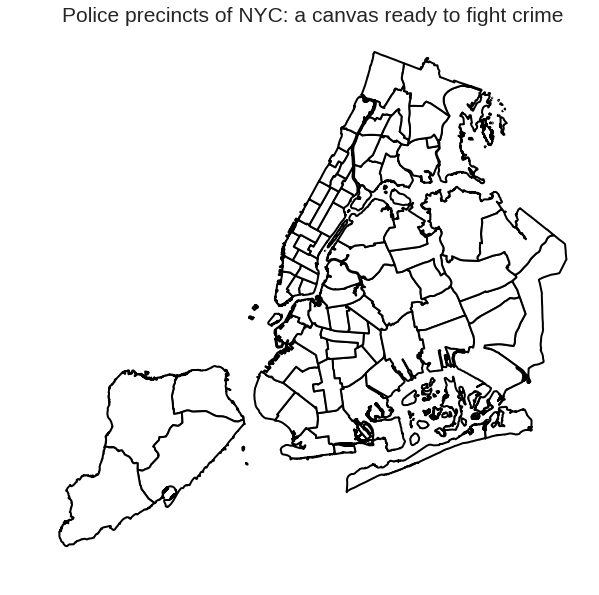

In [9]:
cp.choroplethNYC(policePreshp, column=None, color="white", edgecolor="black", lw=2);
pl.title("Police precincts of NYC: a canvas ready to fight crime", fontsize = 21);

# <font color=Maroon>1. Time domain exploratory analysis</font>


## <font color=Maroon>1.1 Obtain the historical data for 2000-2016 for all NYC police precincts</font>
Obtain the data from NYC.gov. It is an excel file called seven-major-felony-offenses-by-precinct-2000-2016.xls

In [10]:
url = 'http://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning'
filename =  'seven-major-felony-offenses-by-precinct-2000-2016.xls'

crime = pd.read_excel(url + "/" + filename, header = 1, skip_footer = 20) #index_col=None, header=1,



In [11]:
crime.tail(25)

PCT                                              CRIME    2000    2001  \
591    NaN                  TOTAL SEVEN MAJOR FELONY OFFENSES  2347.0  2048.0   
592  121.0  MURDER & NON NEGL. MANSLAUGHTER               ...     NaN     NaN   
593    NaN             RAPE                                       NaN     NaN   
594    NaN             ROBBERY                                    NaN     NaN   
595    NaN             FELONY ASSAULT                             NaN     NaN   
596    NaN             BURGLARY                                   NaN     NaN   
597    NaN             GRAND LARCENY                              NaN     NaN   
598    NaN  GRAND LARCENY OF MOTOR VEHICLE                ...     NaN     NaN   
599    NaN                  TOTAL SEVEN MAJOR FELONY OFFENSES     NaN     NaN   
600  122.0  MURDER & NON NEGL. MANSLAUGHTER               ...     3.0     4.0   
601    NaN             RAPE                                      19.0     6.0   
602    NaN             ROBBERY                                  126.0    75.0   
603    NaN             FELONY ASSAULT                           157.0   141.0   
604    NaN             BURGLARY                                 292.0   242.0   
605    NaN             GRAND LARCENY                            428.0   434.0   
606    NaN  GRAND LARCENY OF MOTOR VEHICLE                ...   667.0   532.0   
607    NaN                  TOTAL SEVEN MAJOR FELONY OFFENSES  1692.0  1434.0   
608  123.0  MURDER & NON NEGL. MANSLAUGHTER               ...     2.0     2.0   
609    NaN             RAPE                                       3.0     2.0   
610    NaN             ROBBERY                                   35.0    30.0   
611    NaN             FELONY ASSAULT                            67.0    57.0   
612    NaN             BURGLARY                                 162.0   140.0   
613    NaN             GRAND LARCENY                            101.0    90.0   
614    NaN  GRAND LARCENY OF MOTOR VEHICLE                ...   266.0   193.0   
615    NaN                  TOTAL SEVEN MAJOR FELONY OFFENSES   636.0   514.0   

       2002    2003    2004    2005    2006    2007    2008    2009    2010  \
591  1968.0  1738.0  1785.0  1812.0  1722.0  1706.0  1692.0  1505.0  1547.0   
592     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
593     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
594     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
595     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
596     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
597     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
598     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
599     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
600     3.0     0.0     1.0     5.0     2.0     3.0     7.0     3.0     2.0   
601    18.0    16.0    10.0    14.0    14.0     8.0    11.0     9.0    18.0   
602    81.0    86.0   128.0   128.0   103.0   131.0   115.0   108.0   116.0   
603   137.0   113.0   137.0   127.0    90.0    89.0    95.0   114.0   141.0   
604   306.0   222.0   258.0   248.0   194.0   293.0   289.0   233.0   203.0   
605   423.0   527.0   565.0   532.0   535.0   513.0   570.0   454.0   410.0   
606   386.0   288.0   257.0   230.0   265.0   222.0   170.0   158.0   118.0   
607  1354.0  1252.0  1356.0  1284.0  1203.0  1259.0  1257.0  1079.0  1008.0   
608     0.0     1.0     1.0     1.0     2.0     2.0     1.0     1.0     2.0   
609     4.0     4.0     3.0     3.0     0.0     2.0     5.0     4.0     2.0   
610    29.0    33.0    29.0    44.0    29.0    28.0    37.0    35.0    22.0   
611    50.0    49.0    56.0    55.0    25.0    56.0    37.0    50.0    48.0   
612   153.0   112.0   114.0   138.0   130.0   140.0   163.0   102.0   111.0   
613   116.0   137.0   166.0   233.0   175.0   181.0   191.0   171.0   147.0   
614 

In [12]:
crime.shape

(616, 19)

In [13]:
crimeClean = crime.copy()

In [14]:
# Assemble list of unique precint numbers, and drop the NA values 
precintNums = list(crime.PCT.dropna().unique())


In [15]:
# Allocate precinct numbers to the Nan's
## BRUTE FORCE  :) 

rowsPerPrecinct = 8

for i in precintNums:
    pctIndex = crime[crime.PCT == i].index
    crimeClean.PCT[pctIndex[0] : pctIndex[0] + rowsPerPrecinct] = i


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
crimeLabels = list(crimeClean.CRIME.dropna().unique())
crimeLabels 

['MURDER & NON NEGL. MANSLAUGHTER                                ',
 'RAPE                                  ',
 'ROBBERY                               ',
 'FELONY ASSAULT                        ',
 'BURGLARY                              ',
 'GRAND LARCENY                         ',
 'GRAND LARCENY OF MOTOR VEHICLE                                  ',
 'TOTAL SEVEN MAJOR FELONY OFFENSES']

In [17]:
# There are strange whitespaces after the CRIME names. Create a dictionary to reassign
 
renameCrimeAssign = { u'MURDER & NON NEGL. MANSLAUGHTER                                ' : 
                      u'MURDER & NON NEGL. MANSLAUGHTER', 
                      u'RAPE                                  ' : 
                      u'RAPE', 
                      u'ROBBERY                               ' : 
                      u'ROBBERY', 
                      u'FELONY ASSAULT                        ' : 
                      u'FELONY ASSAULT', 
                      u'BURGLARY                              ' : 
                      u'BURGLARY', 
                      u'GRAND LARCENY                         ' : 
                      u'GRAND LARCENY', 
                      u'GRAND LARCENY OF MOTOR VEHICLE                                  ' : 
                      u'GRAND LARCENY OF MOTOR VEHICLE', 
                      u'TOTAL SEVEN MAJOR FELONY OFFENSES' : 
                      u'TOTAL SEVEN MAJOR FELONY OFFENSES'}

In [18]:
# Reassign names according to the dictionary
crimeClean.CRIME = crimeClean.CRIME.map(renameCrimeAssign)

In [19]:
#Similarly for the columns, there are a mix of formats.. let's clean it up
crimeClean.columns

Index([  'PCT', 'CRIME',    2000,    2001,    2002,    2003,    2004,    2005,
        '2006',  '2007',  '2008',  '2009',    2010,  '2011',    2012,    2013,
          2014,    2015,    2016],
      dtype='object')

In [20]:
# new dictionary colUpdate with all column names as strings
colUpdate = { 2000 : u'2000',
              2001 : u'2001',     
              2002 : u'2002',
              2003 : u'2003',     
              2004 : u'2004',
              2005 : u'2005',
              2010 : u'2010',
              2012 : u'2012',
              2013 : u'2013', 
              2014 : u'2014',
              2015 : u'2015',
              2016 : u'2016'}
crimeClean.rename(columns = colUpdate, inplace=True)
crimeClean.columns


Index(['PCT', 'CRIME', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016'],
      dtype='object')

### Removing 'etch' records

**Referring to the footnotes**

*The 121 pct was created on 7-1-2013 from parts of the 120 and 122 precinct.  Therefore statistics for 120 and 122 precincts following 2012 are not comparable to earlier years.*

Given we only have records for the last four (4) years for precinct 121, we could either choose to drop the PCT, replace the Nan entries with zeros, or use some other form of averaging approach. 

Also, be mindful of changes in trend for precincts 120 and 122. We drop PCT 121, although may add back in later once we understand the data further.

In [21]:
#crimeClean = crimeClean[crimeClean.PCT != 121]
crimeClean.fillna(0).describe()

PCT         2000         2001         2002         2003  \
count  616.000000   616.000000   616.000000   616.000000   616.000000   
mean    63.324675   599.519481   528.922078   502.626623   477.496753   
std     35.912248   881.282989   787.327589   735.132668   696.062917   
min      1.000000     0.000000     0.000000     0.000000     0.000000   
25%     32.000000    52.500000    49.250000    47.000000    45.000000   
50%     66.000000   332.000000   292.500000   283.500000   262.500000   
75%    100.000000   641.500000   571.250000   557.000000   518.750000   
max    123.000000  6857.000000  6088.000000  5265.000000  5105.000000   

              2004         2005         2006         2007         2008  \
count   616.000000   616.000000   616.000000   616.000000   616.000000   
mean    461.340909   439.853896   417.798701   392.886364   382.974026   
std     672.021056   631.435236   595.736630   563.096312   547.229489   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      40.000000    43.750000    35.000000    33.750000    30.000000   
50%     257.000000   249.000000   228.500000   210.000000   203.500000   
75%     489.750000   467.250000   450.250000   427.000000   423.500000   
max    4730.000000  4423.000000  4173.000000  3971.000000  3708.000000   

              2009         2010         2011         2012         2013  \
count   616.000000   616.000000   616.000000   616.000000   616.000000   
mean    346.525974   341.282468   346.327922   361.974026   361.477273   
std     497.883513   486.757015   493.210669   516.606635   517.823164   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      24.750000    27.000000    27.000000    28.750000    27.750000   
50%     190.500000   177.000000   181.500000   183.000000   171.000000   
75%     389.000000   385.500000   401.000000   422.000000   433.000000   
max    3330.000000  3103.000000  3393.000000  3780.000000  3902.000000   

              2014         2015         2016  
count   616.000000   616.000000   616.000000  
mean    345.159091   341.149351   328.594156  
std     495.810111   489.549460   479.298564  
min       0.000000     0.000000     0.000000  
25%      29.000000    30.000000    28.750000  
50%     165.000000   159.000000   140.000000  
75%     410.500000   388.500000   384.750000  
max    3751.000000  3506.000000  3287.000000

In [22]:
crimeClean[crimeClean.PCT != 121].describe()

PCT         2000         2001         2002         2003  \
count  608.000000   608.000000   608.000000   608.000000   608.000000   
mean    62.565789   607.407895   535.881579   509.240132   483.779605   
std     35.528427   884.362126   790.138554   737.678203   698.458739   
min      1.000000     0.000000     0.000000     0.000000     0.000000   
25%     31.500000    57.750000    56.750000    52.500000    48.750000   
50%     64.500000   338.000000   296.500000   287.500000   264.500000   
75%     95.500000   645.000000   580.250000   559.500000   522.500000   
max    123.000000  6857.000000  6088.000000  5265.000000  5105.000000   

              2004         2005         2006         2007         2008  \
count   608.000000   608.000000   608.000000   608.000000   608.000000   
mean    467.411184   445.641447   423.296053   398.055921   388.013158   
std     674.331052   633.547053   597.702894   564.973662   549.043166   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      49.000000    44.750000    38.000000    37.000000    33.750000   
50%     260.500000   253.000000   232.500000   213.500000   208.500000   
75%     493.000000   469.500000   456.500000   434.000000   429.750000   
max    4730.000000  4423.000000  4173.000000  3971.000000  3708.000000   

              2009         2010         2011         2012         2013  \
count   608.000000   608.000000   608.000000   608.000000   608.000000   
mean    351.085526   345.773026   350.884868   366.736842   364.430921   
std     499.551419   488.364400   494.834504   518.314802   520.220349   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      32.000000    31.000000    29.000000    30.000000    27.750000   
50%     195.500000   183.000000   186.500000   185.000000   171.500000   
75%     394.000000   394.500000   403.500000   431.000000   434.000000   
max    3330.000000  3103.000000  3393.000000  3780.000000  3902.000000   

              2014         2015         2016  
count   608.000000   608.000000   608.000000  
mean    346.480263   342.121711   329.842105  
std     497.727100   491.234184   481.179329  
min       0.000000     0.000000     0.000000  
25%      29.000000    30.000000    28.750000  
50%     165.000000   159.000000   141.000000  
75%     412.750000   388.500000   384.750000  
max    3751.000000  3506.000000  3287.000000

In [23]:
crimeClean = crimeClean[crimeClean.PCT != 121]

In [24]:
crimeClean.shape

(608, 19)

In [25]:
crimeClean.PCT = crimeClean.PCT.astype(int)
#crimeClean.a = df.a.astype(float)

In [26]:
###############################################################################
# Convert columns 2013 - 2016 to floats instead of int to make consistent
convertYears = ['2013', '2014', '2015', '2016']
for i in convertYears:
    crimeClean[i] = crimeClean[i].astype(float)

    

In [27]:
crimeClean.head(15)

PCT                              CRIME    2000    2001    2002    2003  \
0     1    MURDER & NON NEGL. MANSLAUGHTER     3.0     1.0     2.0     2.0   
1     1                               RAPE    12.0     5.0    10.0    11.0   
2     1                            ROBBERY   252.0   188.0   210.0   164.0   
3     1                     FELONY ASSAULT   139.0   164.0   147.0   134.0   
4     1                           BURGLARY   475.0   437.0   297.0   403.0   
5     1                      GRAND LARCENY  2358.0  2117.0  1896.0  1803.0   
6     1     GRAND LARCENY OF MOTOR VEHICLE   199.0   157.0   153.0   132.0   
7     1  TOTAL SEVEN MAJOR FELONY OFFENSES  3438.0  3069.0  2715.0  2649.0   
8     5    MURDER & NON NEGL. MANSLAUGHTER     4.0     3.0     0.0     3.0   
9     5                               RAPE     9.0     3.0    12.0     7.0   
10    5                            ROBBERY   351.0   261.0   196.0   148.0   
11    5                     FELONY ASSAULT   190.0   147.0   108.0   100.0   
12    5                           BURGLARY   285.0   247.0   212.0   215.0   
13    5                      GRAND LARCENY   824.0   697.0   687.0   681.0   
14    5     GRAND LARCENY OF MOTOR VEHICLE   117.0   100.0    94.0    77.0   

      2004    2005    2006    2007    2008    2009    2010    2011    2012  \
0      2.0     0.0     1.0     0.0     1.0     2.0     2.0     0.0     1.0   
1     11.0     5.0     4.0     7.0    12.0     4.0     6.0    13.0    10.0   
2    154.0   172.0   119.0   128.0   108.0   106.0    96.0   102.0    81.0   
3    129.0   121.0    94.0    90.0    83.0    83.0    68.0    94.0   110.0   
4    246.0   293.0   255.0   231.0   189.0   207.0   170.0   155.0   188.0   
5   1708.0  1624.0  1462.0  1395.0  1258.0  1122.0  1065.0   979.0   985.0   
6    133.0    90.0    78.0    63.0    57.0    54.0    38.0    59.0    41.0   
7   2383.0  2305.0  2013.0  1914.0  1708.0  1578.0  1445.0  1402.0  1416.0   
8      1.0     4.0     2.0     2.0     2.0     1.0     1.0     0.0     3.0   
9      7.0    13.0     5.0     4.0     2.0     6.0    10.0    11.0    12.0   
10   136.0   134.0   132.0   151.0   131.0   125.0   106.0   127.0   122.0   
11    95.0    80.0   104.0   129.0   151.0   153.0   128.0   117.0   157.0   
12   173.0   158.0   152.0   122.0   150.0   141.0   127.0   120.0   138.0   
13   688.0   674.0   605.0   582.0   573.0   528.0   582.0   560.0   548.0   
14    70.0    68.0    40.0    41.0    20.0    21.0    15.0    27.0    21.0   

      2013    2014    2015    2016  
0      0.0     0.0     1.0     0.0  
1     12.0     8.0     7.0     9.0  
2     68.0    50.0    79.0    60.0  
3     87.0    76.0    86.0    78.0  
4    171.0   145.0   138.0   117.0  
5   1051.0   896.0  1114.0  1081.0  
6     27.0    33.0    21.0    50.0  
7   1416.0  1208.0  1446.0  1395.0  
8      3.0     2.0     1.0     0.0  
9      5.0     4.0    10.0     8.0  
10   102.0    76.0   100.0   102.0  
11   167.0   125.0   140.0   135.0  
12    92.0   101.0    86.0    81.0  
13   599.0   536.0   559.0   563.0  
14    12.0    26.0    21.0    10.0

In [28]:
crimeClean.describe()

PCT         2000         2001         2002         2003  \
count  608.000000   608.000000   608.000000   608.000000   608.000000   
mean    62.565789   607.407895   535.881579   509.240132   483.779605   
std     35.528427   884.362126   790.138554   737.678203   698.458739   
min      1.000000     0.000000     0.000000     0.000000     0.000000   
25%     31.500000    57.750000    56.750000    52.500000    48.750000   
50%     64.500000   338.000000   296.500000   287.500000   264.500000   
75%     95.500000   645.000000   580.250000   559.500000   522.500000   
max    123.000000  6857.000000  6088.000000  5265.000000  5105.000000   

              2004         2005         2006         2007         2008  \
count   608.000000   608.000000   608.000000   608.000000   608.000000   
mean    467.411184   445.641447   423.296053   398.055921   388.013158   
std     674.331052   633.547053   597.702894   564.973662   549.043166   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      49.000000    44.750000    38.000000    37.000000    33.750000   
50%     260.500000   253.000000   232.500000   213.500000   208.500000   
75%     493.000000   469.500000   456.500000   434.000000   429.750000   
max    4730.000000  4423.000000  4173.000000  3971.000000  3708.000000   

              2009         2010         2011         2012         2013  \
count   608.000000   608.000000   608.000000   608.000000   608.000000   
mean    351.085526   345.773026   350.884868   366.736842   364.430921   
std     499.551419   488.364400   494.834504   518.314802   520.220349   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      32.000000    31.000000    29.000000    30.000000    27.750000   
50%     195.500000   183.000000   186.500000   185.000000   171.500000   
75%     394.000000   394.500000   403.500000   431.000000   434.000000   
max    3330.000000  3103.000000  3393.000000  3780.000000  3902.000000   

              2014         2015         2016  
count   608.000000   608.000000   608.000000  
mean    346.480263   342.121711   329.842105  
std     497.727100   491.234184   481.179329  
min       0.000000     0.000000     0.000000  
25%      29.000000    30.000000    28.750000  
50%     165.000000   159.000000   141.000000  
75%     412.750000   388.500000   384.750000  
max    3751.000000  3506.000000  3287.000000

In [29]:
crimeClean.tail(3)

PCT                              CRIME   2000   2001   2002   2003  \
613  123                      GRAND LARCENY  101.0   90.0  116.0  137.0   
614  123     GRAND LARCENY OF MOTOR VEHICLE  266.0  193.0  143.0  131.0   
615  123  TOTAL SEVEN MAJOR FELONY OFFENSES  636.0  514.0  495.0  467.0   

      2004   2005   2006   2007   2008   2009   2010   2011   2012   2013  \
613  166.0  233.0  175.0  181.0  191.0  171.0  147.0  175.0  183.0  171.0   
614   95.0   96.0  114.0   87.0   81.0   51.0   39.0   48.0   31.0   40.0   
615  464.0  570.0  475.0  496.0  515.0  414.0  371.0  413.0  396.0  378.0   

      2014   2015   2016  
613  194.0  163.0  145.0  
614   30.0   20.0   23.0  
615  378.0  348.0  302.0

## <font color=Maroon>1.2 Remove outliers (likely wrongly input data) </font>
 

In the data downloaded previously there was an incorrect set of rows for one precinct. We should be able to see this when we plot the time series. The values were obviously wrong (extremely large for all crimes). 



### Notes on check for outliers

I checked for outliers, and there didn't appear to be any in the data downloaded. 

I have some charts to convey this further in the notebook. There were some extreme variances, e.g. observations a large number of deviations from the mean, although these didn't appear to be isolated and reflected potentially what we may expect to see in precincts with higher occurences of crime.

##  <font color=Maroon> 1.3  Plot the time series for each of the seven major felonies and for the total (aggregation of all felonies). </font>

We plot each of the time series by Crime type and precinct over time. We moderated the transparency of the lines to see if there are common themes in the time series, and overlap amongst the lines. 

We are seeking to cluster the time series in future, so this will help us to identify commons trends amongst the precincts.

In [30]:
felonyTypes = list(crimeClean.CRIME.dropna().unique())
felonyTypes

['MURDER & NON NEGL. MANSLAUGHTER',
 'RAPE',
 'ROBBERY',
 'FELONY ASSAULT',
 'BURGLARY',
 'GRAND LARCENY',
 'GRAND LARCENY OF MOTOR VEHICLE',
 'TOTAL SEVEN MAJOR FELONY OFFENSES']

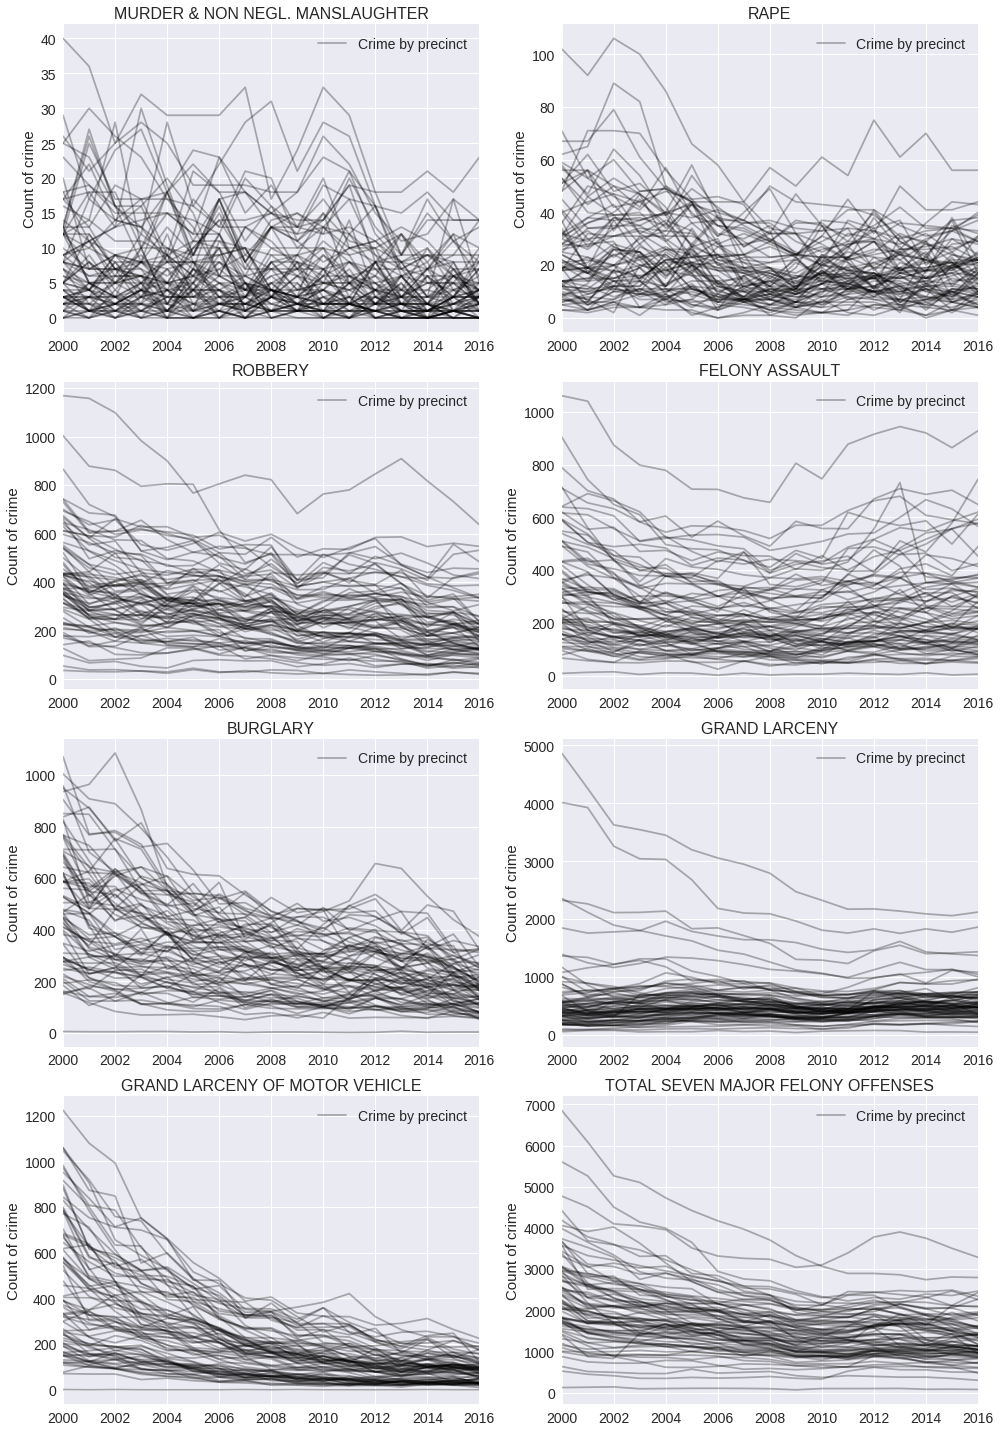

In [31]:
fig = pl.figure(figsize=(14, 20))

for i, lab in enumerate(felonyTypes):
    ax = fig.add_subplot(4, 2, (i + 1))
    v = crimeClean[crimeClean.CRIME == lab]\
    .drop(['PCT', 'CRIME'], axis = 1).T
    ax.plot(np.arange(2000, 2017, 1), v, 'k-', alpha = 0.3)
    

    pl.xticks(fontsize = 14)
    pl.yticks(fontsize = 14)
    pl.ylabel('Count of crime', fontsize = 15)
    pl.title(lab, fontsize = 16)
    plt.tight_layout()
    ax.set_xlim(2000.01, 2015.99)
    
    blackLine = mlines.Line2D([], [], color = 'k', alpha = 0.3, label = 'Crime by precinct')                          
    plt.legend(handles=[blackLine], fontsize = 14)



### **Figure 1:** Plot of the seven (7) major felony offenses by precinct between 2000 and 2016. 

*The total of all seven crimes by precinct is included in the last panel.*

As observed in the total, most precincts have reported a decrease in total crime between 2000 and 2016.

The decreasing trend is most evident in Burglary, Grand Larceny and Grand Larceny of Motor Vehicle. Robbery also exhibits a decreasing trend, although may not be as pronounced as the others listed.

For Felony Assault, the plot of precincts over time appears U-shaped. It decreases initially, and then increased again from around 2008. We're interested to explore this further.

For the more serious crimes, Murder & non negligent manslaughter, and Rape, the trend may be decreasing, although the time series for each precinct are a lot more variable. We will seek to understand these patterns more.

Some of the counts look rather high. For example, there were 40 murders in a single precinct in 2000, and 32 murders in another observation year 2010. This may be within range, however lets check out how many standard deviations the max of murder observations is away from the mean - and try to understand if this is one particular precinct.

In [32]:
crimeClean[crimeClean.CRIME == 'MURDER & NON NEGL. MANSLAUGHTER']\
    .drop(['PCT', 'CRIME'], axis = 1).describe()

2000       2001       2002       2003       2004       2005  \
count  76.000000  76.000000  76.000000  76.000000  76.000000  76.000000   
mean    8.855263   8.539474   7.723684   7.855263   7.500000   7.092105   
std     7.766087   8.033996   6.925506   7.081815   6.929165   6.066691   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     3.000000   3.000000   2.000000   3.000000   2.000000   3.000000   
50%     7.000000   5.000000   6.000000   6.000000   5.000000   6.000000   
75%    12.250000  12.000000  11.500000  10.000000  10.000000   9.250000   
max    40.000000  36.000000  28.000000  32.000000  29.000000  29.000000   

            2006       2007       2008       2009       2010       2011  \
count  76.000000  76.000000  76.000000  76.000000  76.000000  76.000000   
mean    7.842105   6.526316   6.881579   6.197368   7.052632   6.776316   
std     6.641391   6.660278   6.068426   5.351684   7.040634   6.750010   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     2.000000   2.000000   3.000000   2.000000   2.000000   2.000000   
50%     6.000000   4.000000   4.000000   4.000000   5.000000   5.000000   
75%    12.000000   9.000000  10.250000   9.000000  10.250000  10.000000   
max    29.000000  33.000000  31.000000  24.000000  33.000000  29.000000   

            2012       2013       2014       2015       2016  
count  76.000000  76.000000  76.000000  76.000000  76.000000  
mean    5.513158   4.394737   4.328947   4.631579   4.289474  
std     4.851099   3.956695   4.694360   4.393456   4.304465  
min     0.000000   0.000000   0.000000   0.000000   0.000000  
25%     2.000000   1.000000   1.000000   1.000000   1.000000  
50%     4.000000   3.000000   2.000000   3.000000   3.000000  
75%     8.000000   7.000000   7.000000   6.250000   6.000000  
max    18.000000  18.000000  21.000000  18.000000  23.000000

In [33]:
murderPcts = crimeClean[crimeClean.CRIME == 'MURDER & NON NEGL. MANSLAUGHTER']\
    .drop(['PCT', 'CRIME'], axis = 1)

In [34]:
crimeClean[crimeClean.CRIME == 'MURDER & NON NEGL. MANSLAUGHTER']\
    .drop(['PCT'], axis = 1).columns

Index(['CRIME', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016'],
      dtype='object')

#### Analysis of precinct/s with largest murder counts by year

Below we calculate the deviation from mean of the precincts which have the larget murder count by year. They look large. Anything over 3 s.d. is considerably large. However given these are the maximums the values don't look to extreme (i.e. they are not ~10, or over 100). 

The time series of murder counts above in **Figure 1** does not look overly unsual. There are some large values, however we would assess them as large 'within-range', not large 'imposssible / error'. By this we mean, the counts look plausibly correct and there are likely some good explanations for this, such as a dangerous precinct - one with particularly high crime.

In [35]:
murderDevs = (murderPcts.max() - murderPcts.mean()) / murderPcts.std() 
murderDevs

2000    4.010351
2001    3.418041
2002    2.927774
2003    3.409399
2004    3.102827
2005    3.611177
2006    3.185763
2007    3.974862
2008    3.974412
2009    3.326547
2010    3.685374
2011    3.292393
2012    2.574024
2013    3.438542
2014    3.551294
2015    3.042803
2016    4.346771
dtype: float64

##  <font color=Maroon> 1.4 Calculate the mean and standard deviation in time for each precinct and each crime</font>

### The main part of my answer to this question is completed before the pivot. 

#### There's a title in <font color=Orange> Orange </font> further in the notebook to highlight this

The rest of the analysis is interesting, and may form part of the time series analysis of trends and stationarity in crime means and variance.. so it has been documented as below.

In [36]:
# To calculate means and standard deviations over time, by precinct and crime 
## use groupby function

## We should remove the totals row for each precinct

crimeCleanNoTotal = crimeClean[crimeClean.CRIME != 'TOTAL SEVEN MAJOR FELONY OFFENSES']



In [37]:
# Calculate precinct Means and Std. Devs over time

precinctMeans = crimeCleanNoTotal.groupby(by = "PCT").mean()
precinctStdDevs = crimeCleanNoTotal.groupby(by = "PCT").std()

In [38]:
precinctMeans.head()

2000        2001        2002        2003        2004        2005  \
PCT                                                                           
1    491.142857  438.428571  387.857143  378.428571  340.428571  329.285714   
5    254.285714  208.285714  187.000000  175.857143  167.142857  161.571429   
6    341.000000  305.857143  294.142857  295.428571  310.571429  293.571429   
7    141.428571  127.428571  129.714286  123.428571  122.428571  114.857143   
9    302.142857  238.857143  258.428571  257.285714  249.571429  237.714286   

           2006        2007        2008        2009        2010        2011  \
PCT                                                                           
1    287.571429  273.428571  244.000000  225.428571  206.428571  200.285714   
5    148.571429  147.285714  147.000000  139.285714  138.428571  137.428571   
6    282.714286  262.428571  248.285714  233.285714  218.571429  214.857143   
7    123.428571  122.285714  115.285714  100.285714  100.285714  100.571429   
9    225.571429  217.000000  213.571429  217.571429  198.142857  192.857143   

           2012        2013        2014        2015        2016  
PCT                                                              
1    202.285714  202.285714  172.571429  206.571429  199.285714  
5    143.000000  140.000000  124.285714  131.000000  128.428571  
6    224.857143  243.285714  225.000000  217.285714  198.285714  
7    108.857143  101.571429  104.571429  111.571429  117.571429  
9    202.714286  203.428571  190.142857  191.000000  209.000000

In [39]:
precinctStdDevs.head()

2000        2001        2002        2003        2004        2005  \
PCT                                                                           
1    838.631709  754.324832  673.203146  642.023067  608.921138  579.737215   
5    283.036932  239.055582  234.943256  235.016615  238.113018  232.976291   
6    483.265627  430.921659  403.937878  426.968327  472.190236  468.527074   
7    107.167870   91.602142   90.830821   88.468181   97.373605  107.420402   
9    342.417595  250.777078  272.780655  285.520994  287.265184  269.679263   

           2006        2007        2008        2009        2010        2011  \
PCT                                                                           
1    524.831039  500.757046  451.567640  401.469740  383.005595  347.504299   
5    209.953850  201.204468  199.973332  183.654308  203.577059  194.277171   
6    452.928881  427.678172  402.576582  390.990074  373.788201  349.504139   
7    122.124059  118.626465  115.967976   96.698353   96.397985  106.500168   
9    267.459565  279.366545  272.989534  279.176681  261.690293  259.155956   

           2012        2013        2014        2015        2016  
PCT                                                              
1    351.087698  378.697643  322.697927  403.209151  390.834882  
5    189.882420  211.556139  187.734488  195.743029  198.689756  
6    400.983553  449.462536  402.214288  404.561785  358.250245  
7    119.647299  126.616030  130.701769  141.604917  152.636668  
9    276.110313  315.984101  308.218769  308.186091  338.569540

In [40]:
# Calculate Crime Means and Std. Devs over time

crimeMeans = crimeCleanNoTotal.groupby(by = "CRIME").mean().drop(['PCT'], axis=1)
crimeStdDevs = crimeCleanNoTotal.groupby(by = "CRIME").std().drop(['PCT'], axis=1)

In [41]:
crimeMeans

2000        2001        2002  \
CRIME                                                                 
BURGLARY                         504.631579  431.092105  411.513158   
FELONY ASSAULT                   341.105263  308.592105  278.250000   
GRAND LARCENY                    653.039474  609.592105  602.250000   
GRAND LARCENY OF MOTOR VEHICLE   466.342105  388.565789  350.736842   
MURDER & NON NEGL. MANSLAUGHTER    8.855263    8.539474    7.723684   
RAPE                              27.210526   26.065789   28.210526   
ROBBERY                          428.447368  371.078947  358.276316   

                                       2003        2004        2005  \
CRIME                                                                 
BURGLARY                         383.026316  354.947368  317.328947   
FELONY ASSAULT                   251.828947  245.026316  233.552632   
GRAND LARCENY                    615.144737  641.618421  634.776316   
GRAND LARCENY OF MOTOR VEHICLE   308.065789  274.789474  240.078947   
MURDER & NON NEGL. MANSLAUGHTER    7.855263    7.500000    7.092105   
RAPE                              27.236842   25.065789   24.447368   
ROBBERY                          341.960526  320.697368  325.289474   

                                       2006        2007        2008  \
CRIME                                                                 
BURGLARY                         304.513158  286.342105  272.697368   
FELONY ASSAULT                   227.750000  230.171053  214.263158   
GRAND LARCENY                    613.486842  591.105263  582.131579   
GRAND LARCENY OF MOTOR VEHICLE   207.171053  173.342105  164.236842   
MURDER & NON NEGL. MANSLAUGHTER    7.842105    6.526316    6.881579   
RAPE                              20.065789   17.776316   17.092105   
ROBBERY                          312.355263  286.960526  294.750000   

                                       2009        2010        2011  \
CRIME                                                                 
BURGLARY                         255.657895  244.736842  246.315789   
FELONY ASSAULT                   220.697368  223.105263  243.184211   
GRAND LARCENY                    520.789474  497.828947  506.592105   
GRAND LARCENY OF MOTOR VEHICLE   140.394737  135.907895  122.552632   
MURDER & NON NEGL. MANSLAUGHTER    6.197368    7.052632    6.776316   
RAPE                              15.855263   18.065789   18.684211   
ROBBERY                          244.750000  256.394737  259.434211   

                                       2012        2013        2014  \
CRIME                                                                 
BURGLARY                         252.776316  228.026316  218.828947   
FELONY ASSAULT                   255.947368  265.789474  257.631579   
GRAND LARCENY                    561.828947  594.118421  571.894737   
GRAND LARCENY OF MOTOR VEHICLE   106.342105   97.000000  100.052632   
MURDER & NON NEGL. MANSLAUGHTER    5.513158    4.394737    4.328947   
RAPE                              19.078947   18.013158   17.631579   
ROBBERY                          265.460526  250.381579  215.552632   

                                       2015        2016  
CRIME                                                    
BURGLARY                         196.828947  169.118421  
FELONY ASSAULT                   258.526316  265.210526  
GRAND LARCENY                    573.342105  577.315789  
GRAND LARCENY OF MOTOR VEHICLE    95.500000   82.421053  
MURDER & NON NEGL. MANSLAUGHTER    4.631579    4.289474  
RAPE                              18.710526   18.644737  
ROBBERY                          220.947368  202.368421

In [42]:
crimeStdDevs

2000        2001        2002  \
CRIME                                                                 
BURGLARY                         241.191423  217.055887  215.384648   
FELONY ASSAULT                   206.693691  193.945365  176.843594   
GRAND LARCENY                    766.494783  704.256756  603.300945   
GRAND LARCENY OF MOTOR VEHICLE   301.951058  249.972176  213.784026   
MURDER & NON NEGL. MANSLAUGHTER    7.766087    8.033996    6.925506   
RAPE                              19.204385   19.331036   20.206478   
ROBBERY                          209.276812  194.428651  190.254048   

                                       2003        2004        2005  \
CRIME                                                                 
BURGLARY                         194.953668  162.120687  145.702381   
FELONY ASSAULT                   156.944949  152.965876  143.292651   
GRAND LARCENY                    582.226707  576.099019  509.722136   
GRAND LARCENY OF MOTOR VEHICLE   186.640784  170.060563  144.230257   
MURDER & NON NEGL. MANSLAUGHTER    7.081815    6.929165    6.066691   
RAPE                              18.425250   15.866388   14.478853   
ROBBERY                          174.966697  162.591514  153.130517   

                                       2006        2007        2008  \
CRIME                                                                 
BURGLARY                         139.328341  132.751553  119.980001   
FELONY ASSAULT                   144.803050  139.463294  131.511659   
GRAND LARCENY                    465.472878  443.676326  420.231598   
GRAND LARCENY OF MOTOR VEHICLE   127.329744  103.846368  104.607950   
MURDER & NON NEGL. MANSLAUGHTER    6.641391    6.660278    6.068426   
RAPE                              13.135535   11.369666   12.060047   
ROBBERY                          150.145148  144.219133  149.504080   

                                       2009        2010        2011  \
CRIME                                                                 
BURGLARY                         120.361960  119.734302  120.538371   
FELONY ASSAULT                   148.655039  145.499011  161.138343   
GRAND LARCENY                    381.895913  356.536277  331.614563   
GRAND LARCENY OF MOTOR VEHICLE    90.091077   92.910305   87.499698   
MURDER & NON NEGL. MANSLAUGHTER    5.351684    7.040634    6.750010   
RAPE                              11.131581   10.774458   10.555517   
ROBBERY                          126.193410  140.435046  142.526941   

                                       2012        2013        2014  \
CRIME                                                                 
BURGLARY                         124.093255  112.561447  109.020046   
FELONY ASSAULT                   169.074571  183.318253  175.730691   
GRAND LARCENY                    342.348025  346.312921  332.798821   
GRAND LARCENY OF MOTOR VEHICLE    72.677654   63.838755   66.109383   
MURDER & NON NEGL. MANSLAUGHTER    4.851099    3.956695    4.694360   
RAPE                              12.059589   11.296599   11.178363   
ROBBERY                          151.806143  152.185673  137.236185   

                                       2015        2016  
CRIME                                                    
BURGLARY                          92.003390   81.550306  
FELONY ASSAULT                   174.048918  181.437395  
GRAND LARCENY                    333.981139  340.637606  
GRAND LARCENY OF MOTOR VEHICLE    61.028627   50.818176  
MURDER & NON NEGL. MANSLAUGHTER    4.393456    4.304465  
RAPE                              11.355839   11.031717  
ROBBERY                          137.024075  129.404775

It is helpful to visualize the means and standard deviations of the Crime over time, and Precincts over time.

As a basic analysis, we can assess if there are similiarities in the means, trends over time, visually inspect for stationarity in the mean and/or standard deviations (and we would probably want to test this in future, e.g. in the extra credit part 1).

In [43]:
precinctStatDfs = [precinctMeans, precinctStdDevs]
precinctStatLabels = ['Mean of Crime by Precinct over time', 'Standard Deviation of Crime by Precinct over time']

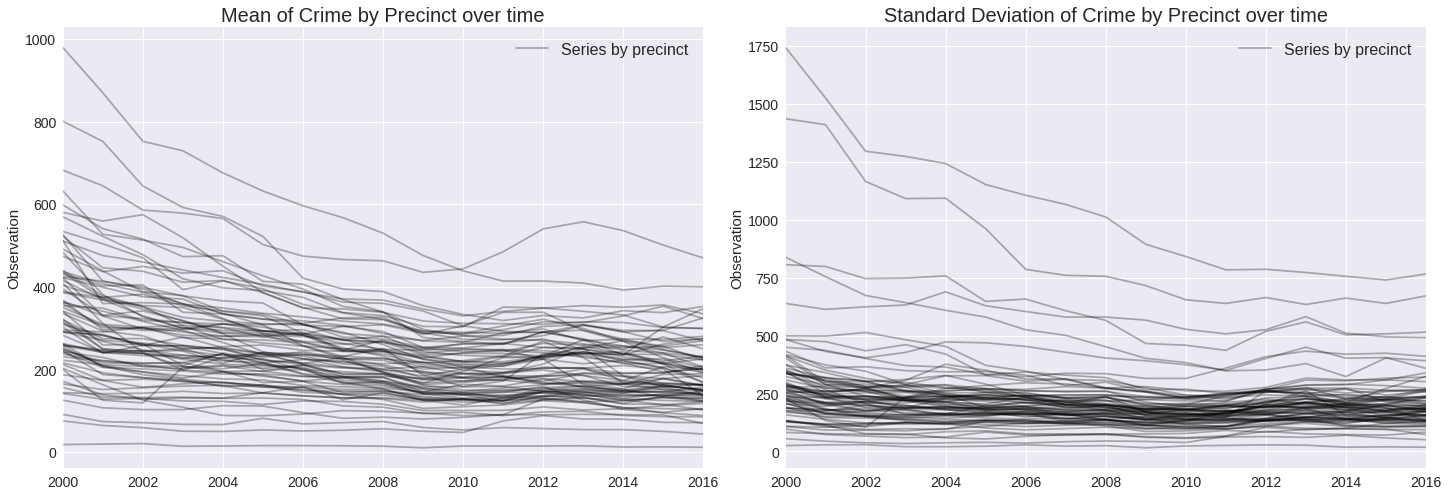

In [44]:
fig = pl.figure(figsize=(20, 7))

for i, dfTitle in enumerate(precinctStatDfs):
    ax = fig.add_subplot(1, 2, (i + 1))
    v = dfTitle.T
    ax.plot(np.arange(2000, 2017, 1), v, 'k-', alpha = 0.3)
    

    pl.xticks(fontsize = 14)
    pl.yticks(fontsize = 14)
    pl.ylabel('Observation', fontsize = 15)
    pl.title(precinctStatLabels[i], fontsize = 20)
    plt.tight_layout()
    ax.set_xlim(2000.01, 2015.99)
    
    blackLine = mlines.Line2D([], [], color = 'k', alpha = 0.3, label = 'Series by precinct')                          
    plt.legend(handles=[blackLine], fontsize = 16)


### **Figure 2:** Plot of Mean *(left)* and Standard Deviation *(right)* of Crime by  precinct between 2000 and 2016. 

A plot of the mean and standard deviation shows both the average and variability of crime decreasing for most (if not all) precincts between 2000 and 2016. Let's explore trends in this further with a clustering analysis in the next section.



In [45]:
crimeStatDfs = [crimeMeans, crimeStdDevs]
crimeStatLabels = ['Mean of Crimes by type over time', 'Standard Deviation of Crimes by type over time']

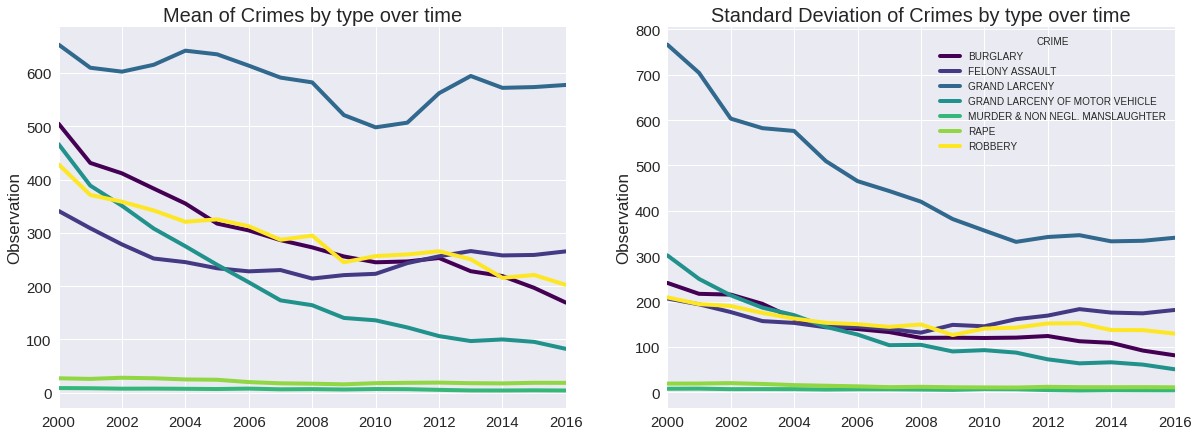

In [46]:

fig = pl.figure(figsize=(20, 7))
ax1 = fig.add_subplot(1, 2, 1)
pl.ylabel('Observation', fontsize = 17)
pl.title(crimeStatLabels[0], fontsize = 20)
crimeMeans.T.plot(ax = ax1, legend = False, fontsize = 15, lw = 4, cmap = plt.cm.viridis); 

ax2 = fig.add_subplot(1, 2, 2)
pl.ylabel('Observation', fontsize = 17)
pl.title(crimeStatLabels[1], fontsize = 20)
crimeStdDevs.T.plot(ax=ax2, fontsize = 15, lw = 4, cmap = plt.cm.viridis);


### **Figure 3:** Plot of Mean (left) and Standard Deviation (right) of Crimes by type between 2000 and 2016. 

A plot of the mean of Crimes by type over time reveals most crimes have decreased on average between 2000 and 2016. Assessing the standard deviation, we also see a trend towards less variability across the reported Crime types.

Reported Grand Larceny is the most prevalent crime, showed a slight decrease in reports over the time period, but variability (standard deviation) decreased substantially. 

The average of Grand Larceny of motor vehicle over the time period also decreased in both mean and variation - i.e. the counts both reduced and were more accurate in 2016 compared with 2000.

More serious crimes like Rape and Murder had low means. We can assess further if the means were increasing or descreasing. They also had fairly consistent reports over time with the lowest variability.

###  <font color=Maroon> EC1 - you can do a quantitative analysis of these time series (trends, periodicity etc.). But I recommend you only do it after you proceed to the other mandatory tasks. </font>

See above - quantitive analysis of trends in mean and standard deviation over time (time series)

##  <font color=Maroon> 1.5 Extract the total crime row for each precinct and cluster the time series. Plot the clusters and discuss the clustering and the trends that you see. </font>

Clustering is undertaken below. You will see a detailed step-by-step approach for our chosen clustering approach **K-means clustering**. 

In [47]:
totcrime = crimeClean[crimeClean.CRIME == 'TOTAL SEVEN MAJOR FELONY OFFENSES']

In [48]:
# Assign new variables crimemean and stdev for the mean and 
## standard deviation of the cluster total over time
totcrime['crimemean'] = totcrime.PCT
totcrime['stdev'] = totcrime.PCT

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
# Calculate the mean and standard deviation of the precint totals over time
## in preparation for clustering
## BRUTE FORCE APPROACH !!    :)

for i in totcrime.index:
    totcrime['crimemean'].loc[i] = totcrime.loc[i].drop(['PCT','CRIME', 'crimemean', 'stdev']).mean() 
    totcrime['stdev'].loc[i] = totcrime.loc[i].drop(['PCT','CRIME', 'crimemean', 'stdev']).std()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
totcrime.head(3)

PCT                              CRIME    2000    2001    2002    2003  \
7     1  TOTAL SEVEN MAJOR FELONY OFFENSES  3438.0  3069.0  2715.0  2649.0   
15    5  TOTAL SEVEN MAJOR FELONY OFFENSES  1780.0  1458.0  1309.0  1231.0   
23    6  TOTAL SEVEN MAJOR FELONY OFFENSES  2387.0  2141.0  2059.0  2068.0   

      2004    2005    2006    2007     ...        2009    2010    2011  \
7   2383.0  2305.0  2013.0  1914.0     ...      1578.0  1445.0  1402.0   
15  1170.0  1131.0  1040.0  1031.0     ...       975.0   969.0   962.0   
23  2174.0  2055.0  1979.0  1837.0     ...      1633.0  1530.0  1504.0   

      2012    2013    2014    2015    2016    crimemean       stdev  
7   1416.0  1416.0  1208.0  1446.0  1395.0  1970.588235  674.856379  
15  1001.0   980.0   870.0   917.0   899.0  1103.058824  233.630443  
23  1574.0  1703.0  1575.0  1521.0  1388.0  1815.647059  294.198900  

[3 rows x 21 columns]

## Clustering of time series

Refering back to **Figure 1**, and trends in total of the seven (7) crimes by precinct; there appears to be trends occuring for the different precinct.

Lets learn more about these trends and aim to group some trends which are observed consistently particularly precincts (for example, increasing trend, decreasing trend, U-shaped trend). 

We'll use a K-means approach to perform the clustering. The involves a number of steps:

**Step 1. Standardize the data (whiten):** We will 'whiten' across time (i.e. for each precinct subtract off the precinct mean and divide by the precinct standard deviation

**Step 2. Select number of clusters:**  For the standard K-means approach, we need to inform the number of clusters to use. We'll determine this by assessing within cluster variance and between cluster variance for a selected range of cluster sizes (e.g. k = 2 through 20), and using the 'elbow' method, determine what the 'optimal' (and I use this term very subjectively) number of clsuters is.

**Step 3. Fit clusters and interpret:** Fit the clusters for 'optimal' choice of k. Determine if the cluster centers provide good insight into the overall trend of precincts which form part of the cluster. If not, it's possible we'll need to choose a new clustering approach.. but let's check it out!

_____________________________________________________________


### Step 1: Standardize the data

In [51]:
totcrime.columns

Index(['PCT', 'CRIME', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', 'crimemean', 'stdev'],
      dtype='object')

In [52]:
totCrimeStandard = totcrime.copy()
columnsStandard = [u'2000',      u'2001',      u'2002',
                   u'2003',      u'2004',      u'2005',      u'2006',      u'2007',
                   u'2008',      u'2009',      u'2010',      u'2011',      u'2012',
                   u'2013',      u'2014',      u'2015',      u'2016']

In [53]:
for i in columnsStandard:
    totCrimeStandard[i] = (totcrime[i] - totcrime.crimemean) / totcrime.stdev

In [54]:
vals = totCrimeStandard.drop(['PCT', 'CRIME', u'crimemean', u'stdev'], axis = 1)

In [55]:
# Check if as expected, means are zero and standard devations are 1

print("Expect means of each row to be = 0\n", vals.mean(1)[:10])
print("Expect stds of each row to be = 1\n", vals.std(1)[:10])

Expect means of each row to be = 0
 7     1.240837e-16
15    2.155139e-16
23   -3.004133e-16
31   -2.563309e-16
39    5.224579e-17
47    3.330669e-16
55    1.044916e-16
63   -1.567374e-16
71    3.918434e-17
79    2.612289e-17
dtype: float64
Expect stds of each row to be = 1
 7     1.0
15    1.0
23    1.0
31    1.0
39    1.0
47    1.0
55    1.0
63    1.0
71    1.0
79    1.0
dtype: float64


### Step 2: Select number of clusters (elbow method)

In [56]:
## Adapted code from Applied Data Science course for 'elbow' output

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'g*-', markersize = 10)
    plt.grid(True)
    pl.xticks(fontsize = 14)
    pl.yticks(fontsize = 14)
    plt.xlabel('Number of clusters', fontsize = 16)
    plt.ylabel('Average within-cluster sum of squares', fontsize = 16)
    plt.title('Elbow for KMeans clustering', fontsize = 20)
    plt.tight_layout()
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'g*-',  markersize = 10)
    plt.grid(True)
    pl.xticks(fontsize = 14)
    pl.yticks(fontsize = 14)
    plt.xlabel('Number of clusters', fontsize = 16)
    plt.ylabel('Percentage of variance explained', fontsize = 16)
    plt.title('Elbow for KMeans clustering', fontsize = 20)
    plt.tight_layout()
    plt.show()


In [57]:
vals = totCrimeStandard[columnsStandard]

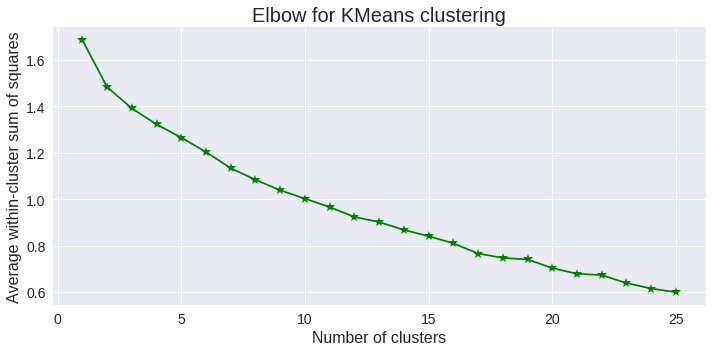

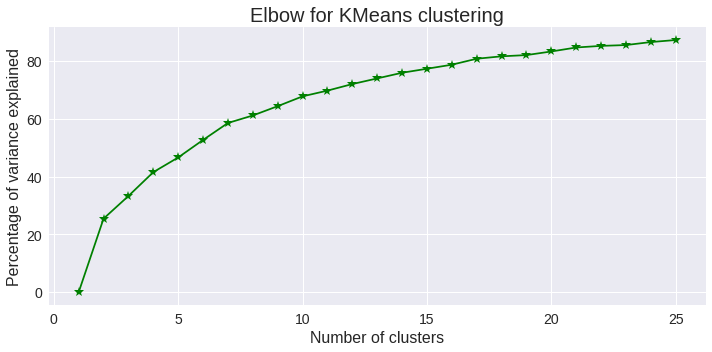

In [58]:
elbow(vals, range(1,26))

### **Figure 4:** Elbow plots for K-means clusters for cluster choice between 1 and 25

Assessing the elbow plots for K-means clustering, we can determine there is some clustering of time series taking place with around 5 clusters explaining approx. 50% of the variance between precincts.

There isn't a large different in percentage of explained variance between four and five clusters

Visually inspecting the elbow charts, it is decided that four (4) clusters is appropriate, and explains just over 40% of the total variance in time series across the precincts. 

**Choose four (4) clusters**

In [59]:
###############################################################################
# Fit K-means algorithm for selected number of clusters (again)
## Adapted code from PUI Homework 11 to fit K-means with seven (7) clusters

#creating a date range: 2000-2016
timeline = pd.date_range('2000', '2017', freq='A')

nc = 4

km = KMeans(n_clusters=nc, random_state=888)

km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=888, tol=0.0001,
    verbose=0)

Cluster centers


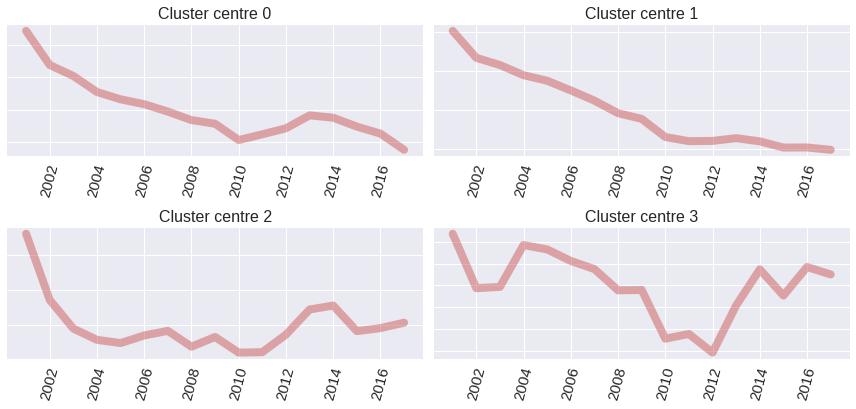

In [60]:
fig = pl.figure(figsize=(12, 8))
for i, Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(3, 2, (i + 1))
    ax.plot(timeline, Xc, lw = 8, alpha = 0.5, c='IndianRed')
    
    pl.title("Cluster centre %d"%(i), fontsize = 16)
    
    
    pl.xticks(fontsize = 15, rotation=75)
    ax.set_yticklabels(['' * len(ax.get_xticklabels())])
    plt.tight_layout()
print("Cluster centers")

### **Figure 5:** K-means cluster centres for total of four clusters

As above, the number of clusters determined for modelling crime by police precinct in New York City was four. Exploring the cluster centres, a decreasing trend is exhibited in Clusters 0, 1 and 2.

Cluster 3 decreases also, however it bounces around a lot with local minimums in years 2002, 2010 and 2012 again, before rising again (there's a local minimum in 2015 also). There may only be a smaller number of precincts in this cluster.

Cluster 1 shows the most gradual and consistent decreasing trend.

Cluster 2 decreases rapidly in the early years between 2000 and 2005 before increasing slights again for the next five years. In 2010 it reaches it's global minimum, before increasing again with a hump in years 2013 and 2014.

Cluster 0 also exihibits the slight hump as described for Cluster 2, although it doesn't have the agressive decrease like Cluster 2 has, so expect hence the distinct clusters for these two.



In [61]:
policePreshp.head()

precinct    shape_leng    shape_area  \
0       1.0  80586.154615  4.730176e+07   
1       5.0  18676.124259  1.808880e+07   
2       6.0  27182.610113  2.213193e+07   
3       7.0  17301.308682  1.836402e+07   
4       9.0  19773.233410  2.139423e+07   

                                            geometry  
0  (POLYGON ((-74.0438776157395 40.69018767637665...  
1  POLYGON ((-73.98863862848766 40.72293372026369...  
2  POLYGON ((-73.99968392160721 40.73855224865976...  
3  POLYGON ((-73.97345389423181 40.718962954076, ...  
4  POLYGON ((-73.97160900246391 40.72672340116989...

In [62]:
policePcts = policePreshp.precinct.values.astype(int)

In [63]:
len(policePcts), len(totCrimeStandard.PCT)

(77, 76)

In [64]:
totCrimeStandard['ClustLabel'] = km.labels_

In [65]:
vals = totCrimeStandard.drop(['CRIME', u'crimemean', u'stdev'], axis = 1)

In [66]:
vals.head()

PCT      2000      2001      2002      2003      2004      2005      2006  \
7     1  2.174406  1.627623  1.103067  1.005268  0.611110  0.495530  0.062846   
15    5  2.897487  1.519242  0.881483  0.547622  0.286526  0.119596 -0.269908   
23    6  1.942063  1.105894  0.827171  0.857763  1.218063  0.813575  0.555247   
31    7  2.152564  0.984810  1.175464  0.651166  0.567755 -0.063785  0.651166   
39    9  2.589303  0.497024  1.144072  1.106288  0.851247  0.459240  0.057787   

        2007      2008      2009      2010      2011      2012      2013  \
7  -0.083852 -0.389102 -0.581736 -0.778815 -0.842532 -0.821787 -0.821787   
15 -0.308431 -0.316991 -0.548126 -0.573807 -0.603769 -0.436839 -0.526724   
23  0.072580 -0.263927 -0.620828 -0.970932 -1.059307 -0.821373 -0.382894   
31  0.555840 -0.028037 -1.279202 -1.279202 -1.255370 -0.564251 -1.171959   
39 -0.225592 -0.338943 -0.206700 -0.849025 -1.023775 -0.697889 -0.674275   

        2014      2015      2016  ClustLabel  
7  -1.130001 -0.777333 -0.852905           1  
15 -0.997553 -0.796381 -0.873426           0  
23 -0.817974 -1.001523 -1.453598           1  
31 -0.921726 -0.337850  0.162616           1  
39 -1.113512 -1.085174 -0.490078           1

In [67]:
for j in range(4):
    print("Precincts in cluster", j)
    print(list(vals.PCT[km.labels_ == j]))
    print("\n")

clustersdf = gp.GeoDataFrame()
clustersdf['precinct'] = vals.PCT
clustersdf['cluster'] = km.labels_

Precincts in cluster 0
[5, 22, 23, 44, 48, 60, 61, 67, 69, 71, 73, 75, 76, 77, 78, 81, 83, 88, 102, 103, 113, 120]


Precincts in cluster 1
[1, 6, 7, 9, 13, 14, 17, 18, 19, 20, 24, 26, 30, 32, 33, 34, 42, 43, 45, 46, 49, 50, 52, 62, 63, 66, 68, 70, 72, 79, 84, 90, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 122, 123]


Precincts in cluster 2
[28, 41, 47, 100, 101, 106]


Precincts in cluster 3
[10, 25, 40, 94]




In [68]:
vals.head()

PCT      2000      2001      2002      2003      2004      2005      2006  \
7     1  2.174406  1.627623  1.103067  1.005268  0.611110  0.495530  0.062846   
15    5  2.897487  1.519242  0.881483  0.547622  0.286526  0.119596 -0.269908   
23    6  1.942063  1.105894  0.827171  0.857763  1.218063  0.813575  0.555247   
31    7  2.152564  0.984810  1.175464  0.651166  0.567755 -0.063785  0.651166   
39    9  2.589303  0.497024  1.144072  1.106288  0.851247  0.459240  0.057787   

        2007      2008      2009      2010      2011      2012      2013  \
7  -0.083852 -0.389102 -0.581736 -0.778815 -0.842532 -0.821787 -0.821787   
15 -0.308431 -0.316991 -0.548126 -0.573807 -0.603769 -0.436839 -0.526724   
23  0.072580 -0.263927 -0.620828 -0.970932 -1.059307 -0.821373 -0.382894   
31  0.555840 -0.028037 -1.279202 -1.279202 -1.255370 -0.564251 -1.171959   
39 -0.225592 -0.338943 -0.206700 -0.849025 -1.023775 -0.697889 -0.674275   

        2014      2015      2016  ClustLabel  
7  -1.130001 -0.777333 -0.852905           1  
15 -0.997553 -0.796381 -0.873426           0  
23 -0.817974 -1.001523 -1.453598           1  
31 -0.921726 -0.337850  0.162616           1  
39 -1.113512 -1.085174 -0.490078           1

In [69]:
timeVals = vals.drop(['PCT', 'ClustLabel'], axis=1)

In [70]:
km.labels_

array([1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 1, 2, 1, 1, 1, 1, 3,
       2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 3, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1], dtype=int32)

In [71]:
timeVals[km.labels_ == 3]

2000      2001      2002      2003      2004      2005      2006  \
47   1.032917 -1.453776 -1.673331  1.214288  1.357475  1.128375  1.371794   
127  1.162949  0.013665  0.392684  0.722798  0.918420  0.563854  0.551628   
183  1.876481  0.790952  0.613183  0.730435  0.567795 -0.010902 -0.298359   
455  0.662369  0.387728  0.525049  1.028557  0.448760  0.555565 -0.131038   

         2007      2008      2009      2010      2011      2012      2013  \
47   0.689266  0.665402 -0.231908 -0.632833 -0.690108 -0.446689 -0.279637   
127  0.025891  0.087023 -1.734714 -1.918111 -2.150413  0.001438  0.673892   
183 -0.476129 -0.332400 -1.164513 -1.062390 -1.081302 -1.228813 -0.192454   
455 -0.695578 -0.848156 -1.763626 -0.848156 -2.251876 -0.161553  1.257425   

         2014      2015      2016  
47  -0.761702 -0.575558 -0.713973  
127 -0.120826  0.845062 -0.035241  
183 -1.160731  0.624530  1.804617  
455  1.104846  0.784432 -0.054749

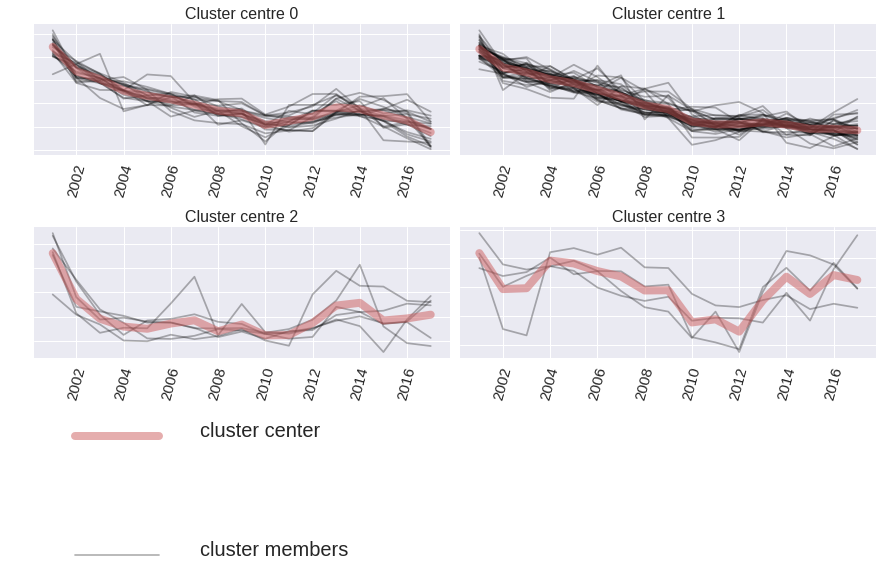

In [72]:
fig = pl.figure(figsize=(12, 8))
for i, Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(3, 2, (i + 1))

    #for v in timeVals[km.labels_ == j]:
    ax.plot(timeline, timeVals[km.labels_ == i].T, 'k-', alpha=0.3)
       # ax.plot(timeline, Xc, lw = 8, alpha = 0.5, c='IndianRed')
    
    
    ax.plot(timeline, Xc, lw = 8, alpha = 0.5, c = 'IndianRed')    
    pl.title("Cluster centre %d"%(i), fontsize = 16)
    
    pl.xticks(fontsize = 15, rotation=75)
    ax.set_yticklabels(['' * len(ax.get_xticklabels())])
    plt.tight_layout()

ax = fig.add_subplot(3, 2, i + 2)
ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
ax.plot([0.1, 0.3], [0.4, 0.4], 'k-', alpha=0.3)
ax.plot([0.1, 0.3], [0.6, 0.6], lw = 8, alpha = 0.5, c = 'IndianRed') 
ax.text(0.4, 0.6, "cluster center", fontsize=20)
ax.text(0.4, 0.4, "cluster members", fontsize=20)
tmp = ax.axis('off')







### **Figure 6:** Plot of precinct time series and cluster centers by cluster

The plots of clusters validate the cluster choice.

**Cluster 1** which was observed as the most consistent gradual cluster likely represents the most common outlook on crime in NYC over the time-period. It has the most member precincts (precincts idenitfying as belonging to that cluster), and exhibits only slight deviations from the gradual decreasing trend.

**Clusters 2 and 3** exhibit the most variability in trend, and this may be because they have only five and four composite precincts in their clusters repsectively.

**Cluster 0** has over 20 composite precincts belonging to it. Each of the member precincts exhibits the hump effect, with increase in crime from 2010 through 2013 before decreasing again.

#  <font color=Maroon> Part 2: Connecting the temporal and spatial components.</font>
##  <font color=Maroon> 2.1 Obtain the NYC precincts geometry and read it in as a shapefile </font>          
(see [the data tips](https://github.com/fedhere/PUI2017_fb55/blob/master/final/PUI2017final_DATA.ipynb))

Completed above

In [73]:
policePreshp.precinct = policePreshp.precinct.values.astype(int)
policePreshp.head(3)

precinct    shape_leng    shape_area  \
0         1  80586.154615  4.730176e+07   
1         5  18676.124259  1.808880e+07   
2         6  27182.610113  2.213193e+07   

                                            geometry  
0  (POLYGON ((-74.0438776157395 40.69018767637665...  
1  POLYGON ((-73.98863862848766 40.72293372026369...  
2  POLYGON ((-73.99968392160721 40.73855224865976...

## <font color=Maroon>2.2   Merge the precincts geodataframe with the dataframe of crime that you used to cluster the time series and plot a choropleth of the clusters. </font>
We plot the clusters on a choropleth and inspect for spatial patterns.

In [74]:
## Cluster dataframe ready for merge
clustersdf.head(10)

precinct  cluster
7          1        1
15         5        0
23         6        1
31         7        1
39         9        1
47        10        3
55        13        1
63        14        1
71        17        1
79        18        1

In [75]:
## Police shp dataframe ready for merge
policePreshp.head()

precinct    shape_leng    shape_area  \
0         1  80586.154615  4.730176e+07   
1         5  18676.124259  1.808880e+07   
2         6  27182.610113  2.213193e+07   
3         7  17301.308682  1.836402e+07   
4         9  19773.233410  2.139423e+07   

                                            geometry  
0  (POLYGON ((-74.0438776157395 40.69018767637665...  
1  POLYGON ((-73.98863862848766 40.72293372026369...  
2  POLYGON ((-73.99968392160721 40.73855224865976...  
3  POLYGON ((-73.97345389423181 40.718962954076, ...  
4  POLYGON ((-73.97160900246391 40.72672340116989...

In [76]:
###############################################################################
# Merged dataframe and check for missing values
## Code adapted from Homework 11

polPreClus = policePreshp.merge(clustersdf, on='precinct', how='left')
print("Length of dataframes:",
      len(polPreClus.precinct),
      len(np.unique(policePreshp.precinct)), 
      len(np.unique(clustersdf.precinct)))

Length of dataframes: 77 77 76


In [77]:
# Check precincts listed in shapefile
np.unique(policePreshp.precinct)

array([  1,   5,   6,   7,   9,  10,  13,  14,  17,  18,  19,  20,  22,
        23,  24,  25,  26,  28,  30,  32,  33,  34,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  52,  60,  61,  62,  63,  66,
        67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  81,
        83,  84,  88,  90,  94, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123])

In [78]:
# Check precincts listed in clustered analysis
np.unique(clustersdf.precinct)

array([  1,   5,   6,   7,   9,  10,  13,  14,  17,  18,  19,  20,  22,
        23,  24,  25,  26,  28,  30,  32,  33,  34,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  52,  60,  61,  62,  63,  66,
        67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  81,
        83,  84,  88,  90,  94, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 120, 122, 123])

We're missing a precinct in the clustering analysis which is present in the shapefile. Recall earlier, we dropped precinct 121. We'll assign a separate cluster to precinct 121 in the shapefile, so our record still appears on the map, and we can identify it hasn't been included in the clustering analysis.

In [79]:
polPreClus[polPreClus.precinct == 121]

precinct     shape_leng    shape_area  \
74       121  138115.721207  4.757161e+08   

                                             geometry  cluster  
74  (POLYGON ((-74.15945602438185 40.6414483333240...      NaN

In [80]:
## Command fills the first Nan value (limit = 1), with the int value 4
polPreClus = polPreClus.fillna(value = int(4), limit = 1)

**Plotting the choropleth**


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


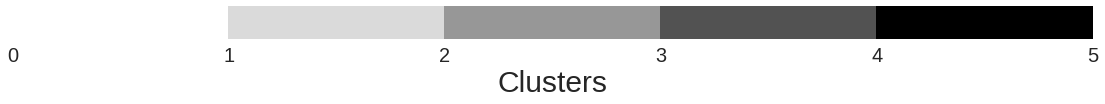

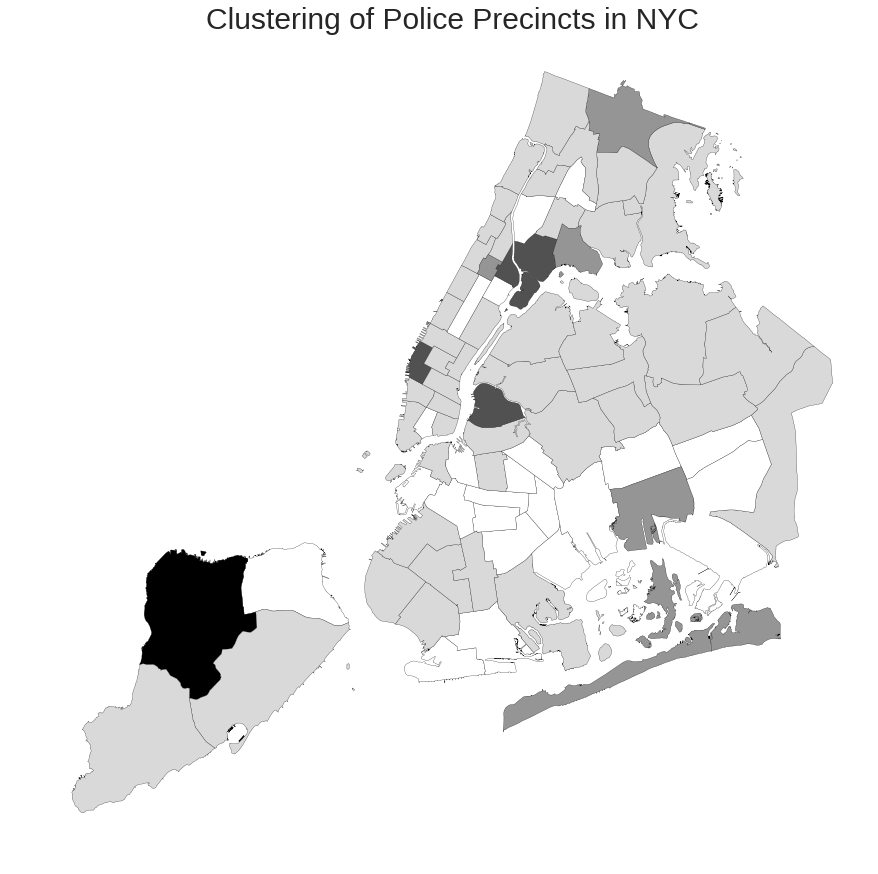

In [81]:
## Code adapted from Homework 11 - cheers!

fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar. 
bounds = range(nc + 2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
cb3.set_label('Clusters', fontsize=30)
font_size = 20 # Adjust as appropriate.
cb3.ax.tick_params(labelsize=font_size)
ax = pl.figure(figsize=(15, 15)).add_subplot(111)
polPreClus.plot(column='cluster', colormap='Greys', 
                edgecolor='black', lw = .25, alpha=1, axes=ax)
pl.title("Clustering of Police Precincts in NYC", fontsize = 30);
tmp = ax.axis('off')

### **Figure 7:** Choropleth of police precinct clusters based on historical crime trends (2000 - 2016)

The plot of police precinct clusters is shown above. The most common cluster with decreasing trend in crime, **Cluster 1** is far reaching across parts of the Bronx, most of Queens, and Manhattan, along with half of Brooklyn, and half of Staten Island.

**Cluster 0** which decreases gradually, followed by a slight hump; spatially covers the other half of Brooklyn, along with parts of Queens, and sporadic part of Manhattan, the Bronx and one precinct on Staten Island.

**Clusters 2 and 3** are the most sporadic, and prevalent again in lower parts of Brooklyn and Queens; and where Manhattan meets thr Bronx in both those Boroughs.

**Clusters 0 and 1** offer the most spatially grouped patterns which don't appear to be random.

###  <font color=Maroon> EC2 visualize each crime by precinct. here you can choose the visual display that you prefer, but not a time series plot (like you did before) or a choropleth (like you will do later). It could be a box and whiskers plot for example</font>

<img src="Faces_of_crime_NYC.png" alt="title" style="float: left;" />

### Extra Credit Figure 1: Plot of the Chernoff faces of crime by precinct.

Each feature on the face represents a different crime of socio-economic variable

   modified item       Var             
 "height of face   " "medianincome"  
 "width of face    " "green"         
 "structure of face" "unemployment"  
 "height of mouth  " "burglary"      
 "width of mouth   " "felonyassault" 
 "smiling          " "glarceny"      
 "height of eyes   " "glmotorvehicle"
 "width of eyes    " "murder"        
 "height of hair   " "rape"          
 "width of hair   "  "robbery"       
 "style of hair   "  "felonyTotal"   
 "height of nose  "  "medianincome"  
 "width of nose   "  "green"         
 "width of ear    "  "unemployment"  
 "height of ear   "  "burglary"

*The visualisation was plotted in R.*

*I ran short of time, although would discuss further comparing the faces and various attributes if I had more time*  

##  <font color=Maroon>2.3 Download the data containing the socioeconomic features to be used as exogenous variables.  </font>
Downloanded the prepared file with socioeconomic features for each precinct: unemployed fraction, median income, fraction of the precinct area that is green. Downloaded it from https://nyu.carto.com via sql. The source sql is  'https://fb55.carto.com:443/api/v2/sql?q=' , the name of the file was *nycsocioeconomicsbyprecinct*


In [82]:
## Updated code from HW7

SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: m
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urlencode({'format': format, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read().decode('utf-8')

In [83]:
query = '''
SELECT  precinct, medianincome, green, unemployment
FROM nycsocioeconomicsbyprecinct
'''

In [84]:
socioeconomic = pd.read_csv(StringIO(queryCartoDB(query)), sep=',')

In [85]:
socioeconomic.head()

precinct   medianincome     green  unemployment
0         1  124092.068749  0.058702      0.021444
1        60   35015.008703  0.173512      0.056448
2        61   65998.923662  0.238375      0.055458
3        63   33655.205265  0.158530      0.031215
4        24  113966.467973  0.166040      0.043461

##  <font color=Maroon>2.4 *Pivot* the crime dataframe so that you have a dataframe with precinct on the index and each crime type on the columns  </font>
Pivot performed below, shortly after calculating the mean and standard deviation of each crime by precinct. 


In [86]:
# Define new columns for 'crimemean' and 'stdev' in crimeClean
crimeClean['crimemean'] = 1
crimeClean['stdev'] = 1

In [87]:
crimeClean.head(2)

PCT                            CRIME  2000  2001  2002  2003  2004  2005  \
0    1  MURDER & NON NEGL. MANSLAUGHTER   3.0   1.0   2.0   2.0   2.0   0.0   
1    1                             RAPE  12.0   5.0  10.0  11.0  11.0   5.0   

   2006  2007  ...    2009  2010  2011  2012  2013  2014  2015  2016  \
0   1.0   0.0  ...     2.0   2.0   0.0   1.0   0.0   0.0   1.0   0.0   
1   4.0   7.0  ...     4.0   6.0  13.0  10.0  12.0   8.0   7.0   9.0   

   crimemean  stdev  
0          1      1  
1          1      1  

[2 rows x 21 columns]

#### The code below is part of my repsonse to Question 1.4 

## <font color=Orange>Calculate the mean and standard deviation in time for each precinct and each crime</font>

In [88]:
# Calculate the mean and standard deviation of the precinct totals over time
## in preparation for clustering
# BRUTE FORCE APPROACH   :)

for i in crimeClean.index:
    crimeClean['crimemean'].loc[i] = crimeClean.loc[i].drop(['PCT','CRIME', 'crimemean', 'stdev']).mean() 
    crimeClean['stdev'].loc[i] = crimeClean.loc[i].drop(['PCT','CRIME', 'crimemean', 'stdev']).std()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [89]:
crimeClean.head()

PCT                            CRIME   2000   2001   2002   2003   2004  \
0    1  MURDER & NON NEGL. MANSLAUGHTER    3.0    1.0    2.0    2.0    2.0   
1    1                             RAPE   12.0    5.0   10.0   11.0   11.0   
2    1                          ROBBERY  252.0  188.0  210.0  164.0  154.0   
3    1                   FELONY ASSAULT  139.0  164.0  147.0  134.0  129.0   
4    1                         BURGLARY  475.0  437.0  297.0  403.0  246.0   

    2005   2006   2007     ...       2009   2010   2011   2012   2013   2014  \
0    0.0    1.0    0.0     ...        2.0    2.0    0.0    1.0    0.0    0.0   
1    5.0    4.0    7.0     ...        4.0    6.0   13.0   10.0   12.0    8.0   
2  172.0  119.0  128.0     ...      106.0   96.0  102.0   81.0   68.0   50.0   
3  121.0   94.0   90.0     ...       83.0   68.0   94.0  110.0   87.0   76.0   
4  293.0  255.0  231.0     ...      207.0  170.0  155.0  188.0  171.0  145.0   

    2015   2016   crimemean       stdev  
0    1.0    0.0    1.058824    0.966345  
1    7.0    9.0    8.588235    3.063063  
2   79.0   60.0  125.705882   56.514118  
3   86.0   78.0  104.882353   28.676825  
4  138.0  117.0  242.176471  107.459431  

[5 rows x 21 columns]

### Pivot (including first check)

In [90]:
crimeClean.pivot(index='PCT', columns='CRIME', values='crimemean').head()

CRIME    BURGLARY  FELONY ASSAULT  GRAND LARCENY  \
PCT                                                
1      242.176471      104.882353    1406.705882   
5      152.941176      130.941176     616.823529   
6      225.588235      114.352941    1183.000000   
7      108.176471      124.411765     317.352941   
9      247.882353      169.647059     833.176471   

CRIME  GRAND LARCENY OF MOTOR VEHICLE  MURDER & NON NEGL. MANSLAUGHTER  \
PCT                                                                      
1                           81.470588                         1.058824   
5                           45.882353                         1.882353   
6                           82.117647                         1.294118   
7                           74.117647                         2.588235   
9                           89.529412                         2.294118   

CRIME       RAPE     ROBBERY  TOTAL SEVEN MAJOR FELONY OFFENSES  
PCT                                                              
1       8.588235  125.705882                        1970.588235  
5       7.529412  147.058824                        1103.058824  
6       9.470588  199.823529                        1815.647059  
7      10.705882  172.000000                         809.352941  
9      15.470588  208.764706                        1566.764706

In [91]:
crimeClean.pivot(index='PCT', columns='CRIME', values='crimemean').shape

(76, 8)

In [92]:
crimepivot = crimeClean.pivot(index='PCT', columns='CRIME', values='crimemean')

In [93]:
crimepivot.head()

CRIME    BURGLARY  FELONY ASSAULT  GRAND LARCENY  \
PCT                                                
1      242.176471      104.882353    1406.705882   
5      152.941176      130.941176     616.823529   
6      225.588235      114.352941    1183.000000   
7      108.176471      124.411765     317.352941   
9      247.882353      169.647059     833.176471   

CRIME  GRAND LARCENY OF MOTOR VEHICLE  MURDER & NON NEGL. MANSLAUGHTER  \
PCT                                                                      
1                           81.470588                         1.058824   
5                           45.882353                         1.882353   
6                           82.117647                         1.294118   
7                           74.117647                         2.588235   
9                           89.529412                         2.294118   

CRIME       RAPE     ROBBERY  TOTAL SEVEN MAJOR FELONY OFFENSES  
PCT                                                              
1       8.588235  125.705882                        1970.588235  
5       7.529412  147.058824                        1103.058824  
6       9.470588  199.823529                        1815.647059  
7      10.705882  172.000000                         809.352941  
9      15.470588  208.764706                        1566.764706

##  <font color=Maroon>2.5 Merge the dataframe with the socioeconomic data with the pivoted crime data,  and merge the precinct geodataframe with it. plot a choropleth of each of the 7 felonies, plus the total crime by precinct </font>

Data cleaned and merged, and crime features renamed to remove the whitespace (because it was annoying).

In [94]:
socioeconomic.shape

(77, 4)

In [95]:
crimSocio = pd.merge(socioeconomic, crimepivot, left_on = 'precinct', right_index=True, how='left')

In [96]:
crimSocio.head()

precinct   medianincome     green  unemployment    BURGLARY  \
0         1  124092.068749  0.058702      0.021444  242.176471   
1        60   35015.008703  0.173512      0.056448  230.588235   
2        61   65998.923662  0.238375      0.055458  445.235294   
3        63   33655.205265  0.158530      0.031215  249.235294   
4        24  113966.467973  0.166040      0.043461  162.411765   

   FELONY ASSAULT  GRAND LARCENY  GRAND LARCENY OF MOTOR VEHICLE  \
0      104.882353    1406.705882                       81.470588   
1      272.529412     519.823529                      151.705882   
2      167.588235     678.294118                      310.411765   
3      153.588235     593.294118                      252.176471   
4      137.705882     568.117647                       91.470588   

   MURDER & NON NEGL. MANSLAUGHTER       RAPE     ROBBERY  \
0                         1.058824   8.588235  125.705882   
1                         7.705882  18.470588  332.529412   
2                         5.352941  13.235294  269.529412   
3                         5.000000  12.529412  242.058824   
4                         2.647059  12.764706  237.705882   

   TOTAL SEVEN MAJOR FELONY OFFENSES  
0                        1970.588235  
1                        1533.352941  
2                        1889.647059  
3                        1507.882353  
4                        1212.823529

In [97]:
crimSocio.columns

Index(['precinct', 'medianincome', 'green', 'unemployment', 'BURGLARY',
       'FELONY ASSAULT', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE',
       'MURDER & NON NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY',
       'TOTAL SEVEN MAJOR FELONY OFFENSES'],
      dtype='object')

In [98]:
# Reassign the CRIME names. Create a dictionary to reassign
 
renameCrimeAssign = { 'BURGLARY' : 'burglary',
                      'FELONY ASSAULT' : 'felonyassault',
                      'GRAND LARCENY' : 'glarceny', 
                      'GRAND LARCENY OF MOTOR VEHICLE' : 'glmotorvehicle',
                      'MURDER & NON NEGL. MANSLAUGHTER' : 'murder', 
                      'RAPE' : 'rape', 
                      'ROBBERY' : 'robbery',
                      'TOTAL SEVEN MAJOR FELONY OFFENSES' : 'felonyTotal' }

In [99]:
crimSocio.rename(columns = renameCrimeAssign, inplace = True)

In [100]:
crimSocio.columns

Index(['precinct', 'medianincome', 'green', 'unemployment', 'burglary',
       'felonyassault', 'glarceny', 'glmotorvehicle', 'murder', 'rape',
       'robbery', 'felonyTotal'],
      dtype='object')

In [101]:
###############################################################################
# Merged dataframe and check for missing values
## Code adapted from Homework 11

precinctShpSocio = polPreClus.merge(crimSocio, on='precinct', how='left')
print("Length of dataframes:",
      len(precinctShpSocio.precinct),
      len(np.unique(crimSocio.precinct)), 
      len(np.unique(polPreClus.precinct)))

Length of dataframes: 77 77 77


In [102]:
#Define missing precinct shape, and then drop Nan's from shp file
MissingPrec =  precinctShpSocio[precinctShpSocio['precinct'] == 121]
precShpSocioClean = precinctShpSocio.dropna(axis = 0)

In [103]:
precShpSocioClean.head()

precinct    shape_leng    shape_area  \
0         1  80586.154615  4.730176e+07   
1         5  18676.124259  1.808880e+07   
2         6  27182.610113  2.213193e+07   
3         7  17301.308682  1.836402e+07   
4         9  19773.233410  2.139423e+07   

                                            geometry  cluster   medianincome  \
0  (POLYGON ((-74.0438776157395 40.69018767637665...      1.0  124092.068749   
1  POLYGON ((-73.98863862848766 40.72293372026369...      0.0   99148.860914   
2  POLYGON ((-73.99968392160721 40.73855224865976...      1.0  119565.099444   
3  POLYGON ((-73.97345389423181 40.718962954076, ...      1.0   44645.989878   
4  POLYGON ((-73.97160900246391 40.72672340116989...      1.0   82391.812180   

      green  unemployment    burglary  felonyassault     glarceny  \
0  0.058702      0.021444  242.176471     104.882353  1406.705882   
1  0.049462      0.046260  152.941176     130.941176   616.823529   
2  0.035655      0.029992  225.588235     114.352941  1183.000000   
3  0.125848      0.052540  108.176471     124.411765   317.352941   
4  0.080894      0.041264  247.882353     169.647059   833.176471   

   glmotorvehicle    murder       rape     robbery  felonyTotal  
0       81.470588  1.058824   8.588235  125.705882  1970.588235  
1       45.882353  1.882353   7.529412  147.058824  1103.058824  
2       82.117647  1.294118   9.470588  199.823529  1815.647059  
3       74.117647  2.588235  10.705882  172.000000   809.352941  
4       89.529412  2.294118  15.470588  208.764706  1566.764706

In [104]:
precShpSocioClean.shape

(76, 16)

For plotting the choropleths of each of the crimes by precinct, we'll normalize by crime type and plot equal quintiles (five categories), for each crime type.

In [105]:
precShpSocioClean.columns

Index(['precinct', 'shape_leng', 'shape_area', 'geometry', 'cluster',
       'medianincome', 'green', 'unemployment', 'burglary', 'felonyassault',
       'glarceny', 'glmotorvehicle', 'murder', 'rape', 'robbery',
       'felonyTotal'],
      dtype='object')

In [106]:
normCols = ['burglary', 'felonyassault','glarceny', 'glmotorvehicle',
            'murder', 'rape', 'robbery',
            'felonyTotal']

In [107]:
precShpSocioNorm = precShpSocioClean.copy()

In [108]:
#Normalize each of the crime columns for quintiles of each crime choropleth
for j in normCols:
    avg = precShpSocioClean[j].mean()
    spr = precShpSocioClean[j].std()
    precShpSocioNorm[j]  = (precShpSocioClean[j] - avg) / spr
    
precShpSocioNorm.head()

precinct    shape_leng    shape_area  \
0         1  80586.154615  4.730176e+07   
1         5  18676.124259  1.808880e+07   
2         6  27182.610113  2.213193e+07   
3         7  17301.308682  1.836402e+07   
4         9  19773.233410  2.139423e+07   

                                            geometry  cluster   medianincome  \
0  (POLYGON ((-74.0438776157395 40.69018767637665...      1.0  124092.068749   
1  POLYGON ((-73.98863862848766 40.72293372026369...      0.0   99148.860914   
2  POLYGON ((-73.99968392160721 40.73855224865976...      1.0  119565.099444   
3  POLYGON ((-73.97345389423181 40.718962954076, ...      1.0   44645.989878   
4  POLYGON ((-73.97160900246391 40.72672340116989...      1.0   82391.812180   

      green  unemployment  burglary  felonyassault  glarceny  glmotorvehicle  \
0  0.058702      0.021444 -0.424089      -0.934032  1.813476       -0.978541   
1  0.049462      0.046260 -1.093275      -0.770976  0.070002       -1.264748   
2  0.035655      0.029992 -0.548486      -0.874772  1.319700       -0.973338   
3  0.125848      0.052540 -1.428970      -0.811832 -0.591007       -1.037675   
4  0.080894      0.041264 -0.381300      -0.528784  0.547549       -0.913731   

     murder      rape   robbery  felonyTotal  
0 -1.004290 -0.990136 -1.109600     0.445635  
1 -0.854715 -1.074262 -0.966673    -0.800127  
2 -0.961555 -0.920032 -0.613488     0.223142  
3 -0.726508 -0.821885 -0.799727    -1.221885  
4 -0.779928 -0.443320 -0.553640    -0.134250

In [109]:
chartLabels = { 'burglary' : 'BURGLARY' ,
                'felonyassault' : 'FELONY ASSAULT',
                'glarceny' : 'GRAND LARCENY', 
                'glmotorvehicle' : 'GRAND LARCENY OF MOTOR VEHICLE',
                'murder' : 'MURDER & NON NEGL. MANSLAUGHTER', 
                'rape' : 'RAPE', 
                'robbery' : 'ROBBERY',
                'felonyTotal' : 'TOTAL SEVEN MAJOR FELONY OFFENSES' }

In [110]:
crimeCols = ['burglary', 'felonyassault','glarceny', 'glmotorvehicle',
            'murder', 'rape', 'robbery']


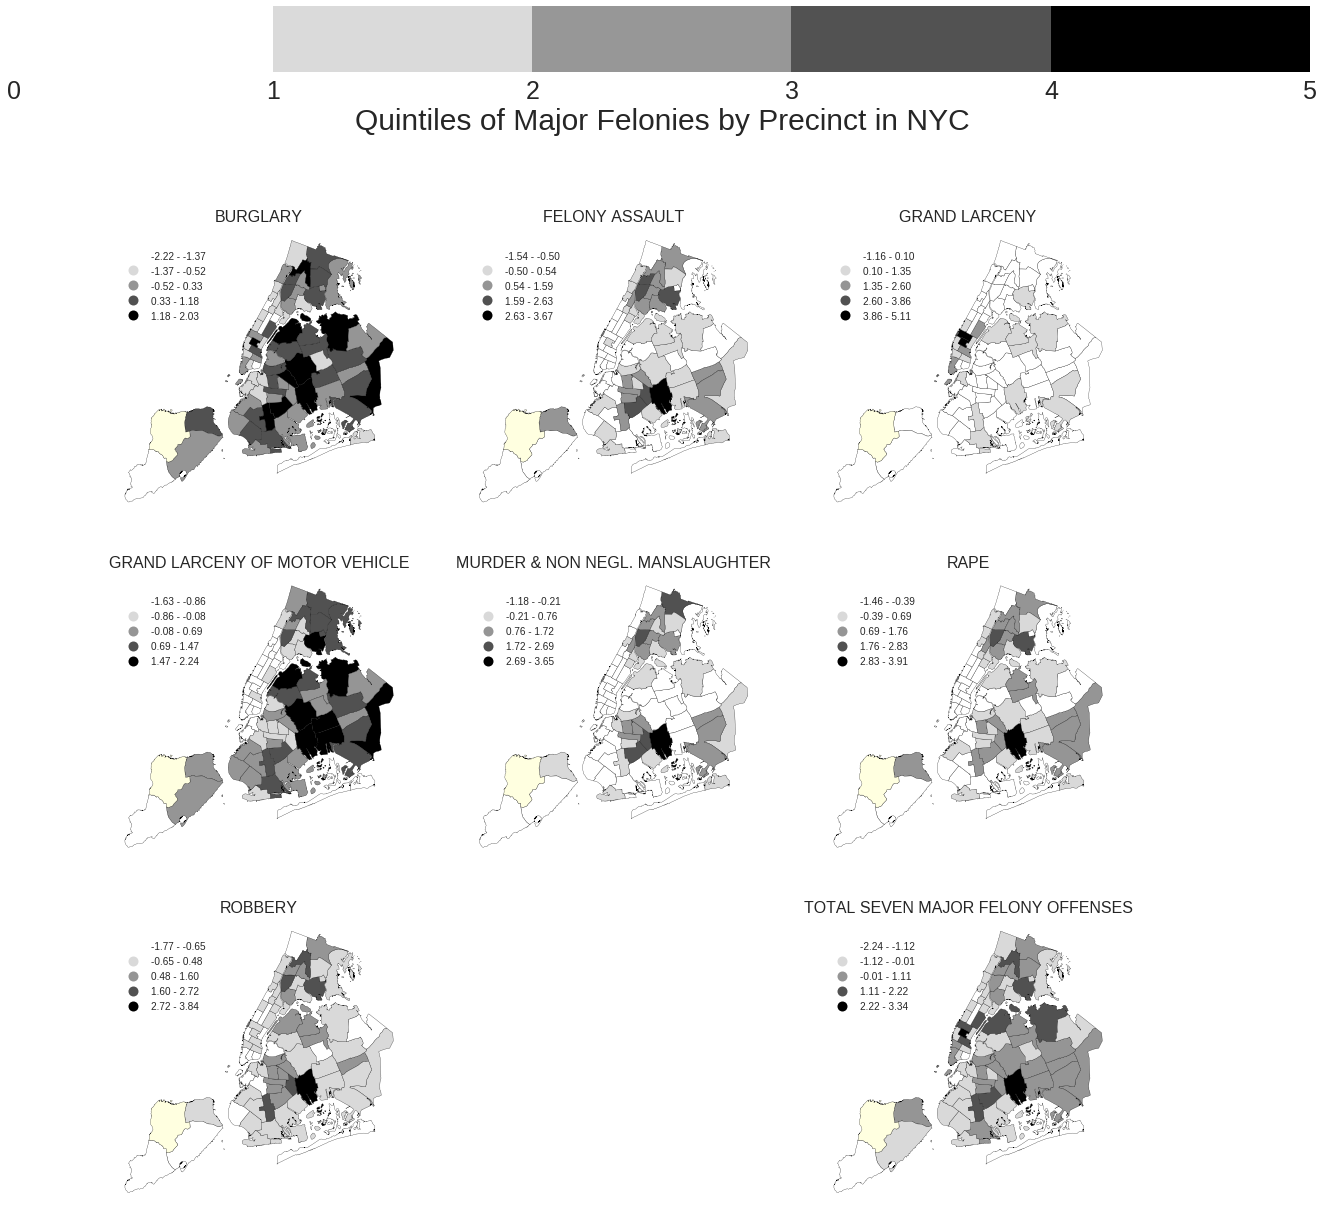

In [111]:
#Plotting the choropleths

fig = pl.figure(figsize=(18, 18))

for i, lab in enumerate(crimeCols):
    
    axRef = fig.add_subplot(3, 3, (i + 1))

    #item, figRef, axes = 
    cp.choroplethNYC(precShpSocioNorm, 
                                     column = lab, cmap = plt.cm.Greys, 
                                     edgecolor = 'black', lw = .25, ax = axRef,
                                     scheme ='equal_interval', k=5 );
    cp.choroplethNYC(MissingPrec, ax = axRef, color = 'LightYellow',
                 edgecolor = 'black', lw = .25);
    pl.title(chartLabels[lab], fontsize = 16);


  #  plt.tight_layout()




axRef = fig.add_subplot(3, 3, i + 2)

## Mad code for the Color bar 
# Code adapted from Homework 11 - cheers!

#fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.0505]) #[0.05, 1.0, 1, 0.15]052
cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar. 
bounds = range(nc + 2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
font_size = 25 # Adjust as appropriate.
cb3.ax.tick_params(labelsize=font_size)
cb3.set_label('Quintiles of Major Felonies by Precinct in NYC', fontsize=30)

tmp = axRef.axis('off')    



axRef = fig.add_subplot(3, 3, i + 3)
cp.choroplethNYC(precShpSocioNorm, 
                 column = 'felonyTotal', cmap = plt.cm.Greys, 
                 edgecolor = 'black', lw = .25, ax = axRef,
                 scheme ='equal_interval', k=5 );
cp.choroplethNYC(MissingPrec, ax = axRef, color = 'LightYellow',
                 edgecolor = 'black', lw = .25);
pl.title(chartLabels['felonyTotal'], fontsize = 16);



### **Figure 8:** Quintile choropleths of seven (7) major felonies in NYC by Crime type; and total *(bottom right)*

The above choropleths show equal interval quintiles for each of the seven (7) major felonies in New York City. Note, the precinct shaded in light yellow was newly defined for tracking crime statistics, and we have excluded it from the analysis. It is pictured for a complete visual of all of NYC's five (5) Boroughs.

The precincts shaded white are in the lowest quintile, reporting the lowest average for each of the crimes. The quintiles in black are the highest quintiles and report the higher averages for each of the crimes. Quintile width within each chart is equal for that crime.

From the charts we can see Burglary, and Grand Larceny of Motor Vehicle both has the highest numbers of precincts in the top quartiles.

Grand Larceny is the crime with the least number of precincts in the higher quartiles. Most are in the lower quartile (it might be interesting to explore this further later, if there is an outlier skewing the data).

Murder, Rape and Robbery - arguably three of the more serious crimes, exhibit similar spatial patterns with respect to their quintiles.

Overall, total of the seven (7) crimes provides an interesting picture. A handful of precincts in the lowest quintile, one on Staten Island, a couple in Manhattan and one nearby Downton Brooklyn. Heavier Crime across outskirts of Queens, Brooklyn and the Bronx; along with Midtown. Only a couple of precincts in the highest quintile overall (nearby Brownesville, and Midtown).




##  <font color=Maroon>2.6 Cluster the data first using the socioeconomic features and then using the 7 felonies  </font>
K-means clustering used again. I guess this uses simple Euclidean distance.

Preprocessing of the data is undertaken to normalize by subtracting the mean and dividing by the standard deviation.


### Normalize the data required for clustering

In [112]:
## Let's revert back to the precShpSocioClean geodataset
precShpSocioClean.columns

Index(['precinct', 'shape_leng', 'shape_area', 'geometry', 'cluster',
       'medianincome', 'green', 'unemployment', 'burglary', 'felonyassault',
       'glarceny', 'glmotorvehicle', 'murder', 'rape', 'robbery',
       'felonyTotal'],
      dtype='object')

In [113]:
## Define new columns to normalize by (both Crime and Socio-economic)
normColsUpd = ['medianincome', 'green', 'unemployment', 
               'burglary', 'felonyassault','glarceny', 
               'glmotorvehicle', 'murder', 'rape', 'robbery',
               'felonyTotal']

#Normalize each of the socio and crime columns for clustering
for j in normColsUpd:
    avg = precShpSocioClean[j].mean()
    spr = precShpSocioClean[j].std()
    precShpSocioNorm[j]  = (precShpSocioClean[j] - avg) / spr
    
precShpSocioNorm.head()

precinct    shape_leng    shape_area  \
0         1  80586.154615  4.730176e+07   
1         5  18676.124259  1.808880e+07   
2         6  27182.610113  2.213193e+07   
3         7  17301.308682  1.836402e+07   
4         9  19773.233410  2.139423e+07   

                                            geometry  cluster  medianincome  \
0  (POLYGON ((-74.0438776157395 40.69018767637665...      1.0      1.780387   
1  POLYGON ((-73.98863862848766 40.72293372026369...      0.0      1.104511   
2  POLYGON ((-73.99968392160721 40.73855224865976...      1.0      1.657722   
3  POLYGON ((-73.97345389423181 40.718962954076, ...      1.0     -0.372331   
4  POLYGON ((-73.97160900246391 40.72672340116989...      1.0      0.650452   

      green  unemployment  burglary  felonyassault  glarceny  glmotorvehicle  \
0 -0.359130     -1.164498 -0.424089      -0.934032  1.813476       -0.978541   
1 -0.426237     -0.371678 -1.093275      -0.770976  0.070002       -1.264748   
2 -0.526514     -0.891418 -0.548486      -0.874772  1.319700       -0.973338   
3  0.128522     -0.171050 -1.428970      -0.811832 -0.591007       -1.037675   
4 -0.197961     -0.531298 -0.381300      -0.528784  0.547549       -0.913731   

     murder      rape   robbery  felonyTotal  
0 -1.004290 -0.990136 -1.109600     0.445635  
1 -0.854715 -1.074262 -0.966673    -0.800127  
2 -0.961555 -0.920032 -0.613488     0.223142  
3 -0.726508 -0.821885 -0.799727    -1.221885  
4 -0.779928 -0.443320 -0.553640    -0.134250

#### Normalization check

In [114]:
## Want to check each of the columns we normalized
vals = precShpSocioNorm[normColsUpd]

In [115]:
# Check if as expected, means are zero and standard devations are 1

print("Expect means of each column to be = 0\n", vals.mean(0))

print("Expect stds of each column to be = 1\n", vals.std(0))

Expect means of each column to be = 0
 medianincome     -1.154048e-16
green             2.739037e-17
unemployment     -8.764919e-18
burglary         -4.090295e-17
felonyassault    -3.476751e-16
glarceny          7.888427e-17
glmotorvehicle   -3.359885e-16
murder            1.752984e-17
rape             -1.168656e-16
robbery           3.213803e-17
felonyTotal       2.249662e-16
dtype: float64
Expect stds of each column to be = 1
 medianincome      1.0
green             1.0
unemployment      1.0
burglary          1.0
felonyassault     1.0
glarceny          1.0
glmotorvehicle    1.0
murder            1.0
rape              1.0
robbery           1.0
felonyTotal       1.0
dtype: float64


### Clustering on Socio-economic variables only

In [116]:
## We only want to cluster firstly on the socio-economic variables

colSocio = ['medianincome', 'green', 'unemployment']
vals = precShpSocioNorm[colSocio]

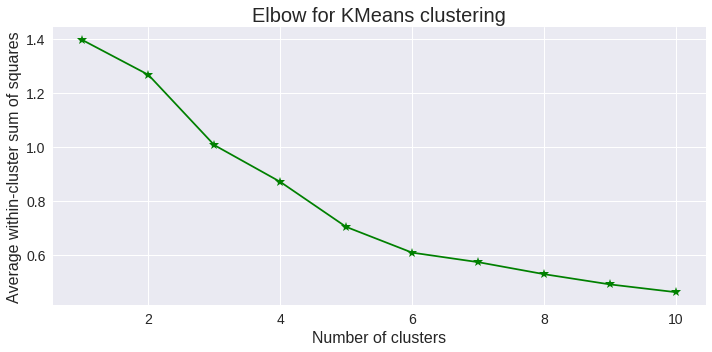

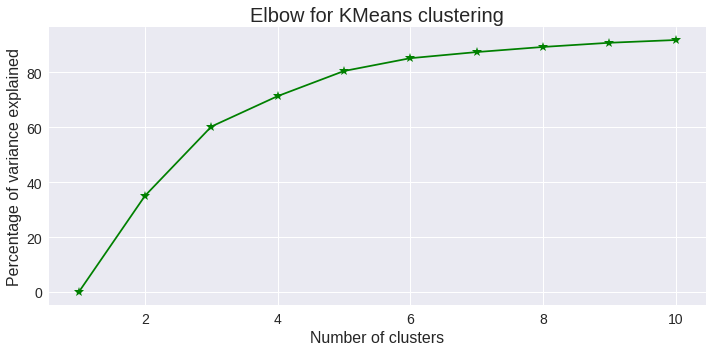

In [117]:
elbow(vals, range(1,11))

### **Figure 9:** Elbow plots for K-means clusters for cluster choice between 1 and 10

Again reviewing elbow plots for selection of number of Clusters.

For the socio-economic variables, six (6) clusters seems appropriate. The marginal improvements in percentage of variance explained with addition of extra clusters is fairly constant after six clusters.

Over 70% of the variance can be explained with six (5) clusters. We might consider dropping one or two clusters eventually if they are small, or it looks like two patterns are emerging which demonstrate the same feature and could be combined.

**Choose six (6) clusters**

In [118]:
###############################################################################
# Fit K-means algorithm for selected number of clusters (again)
## Adapted code from PUI Homework 11 to fit K-means with six (6) clusters

nc = 6

km = KMeans(n_clusters=nc, random_state=888)

km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=888, tol=0.0001,
    verbose=0)

In [119]:
for j in range(nc):
    print("Precincts in cluster", j)
    print(list(precShpSocioNorm.precinct[km.labels_ == j]))
    print("\n")

precShpSocioNorm['socioCluster'] = km.labels_

Precincts in cluster 0
[40, 41, 42, 43, 44, 46, 47, 48, 67, 69, 73, 75, 103, 113]


Precincts in cluster 1
[7, 9, 26, 62, 63, 66, 68, 70, 72, 90, 94, 100, 102, 104, 105, 107, 108, 109, 111, 112, 114, 115, 120, 122, 123]


Precincts in cluster 2
[22]


Precincts in cluster 3
[1, 5, 6, 10, 13, 14, 17, 18, 19, 20, 24, 28, 76, 84]


Precincts in cluster 4
[25, 33, 34, 45, 50, 52, 60, 61, 78, 101, 110]


Precincts in cluster 5
[23, 30, 32, 49, 71, 77, 79, 81, 83, 88, 106]




From the above output of precincts by cluster, we can see Cluster 22 is a single point in a cluster all on it's own. This appears to be an outlier. We'll plot is on our choropleth as an outlier also, similar to the observation removed previously for Staten Island, and see if there is a possible explanation for this.

In [120]:
Prec22 =  precinctShpSocio[precinctShpSocio['precinct'] == 22]

In [121]:
vals.head()

medianincome     green  unemployment
0      1.780387 -0.359130     -1.164498
1      1.104511 -0.426237     -0.371678
2      1.657722 -0.526514     -0.891418
3     -0.372331  0.128522     -0.171050
4      0.650452 -0.197961     -0.531298

Let's inspect a couple of scatter plots also to assess if there are natural patterns related to the variables we fitted. Let's plot Unemployment against Median Income which seems like there should be some natural economic relationships.

Similarly, a plot Green space against Median Income should also have some natural relationships. We hypothesise that wealthier people live in areas with access to more green space.

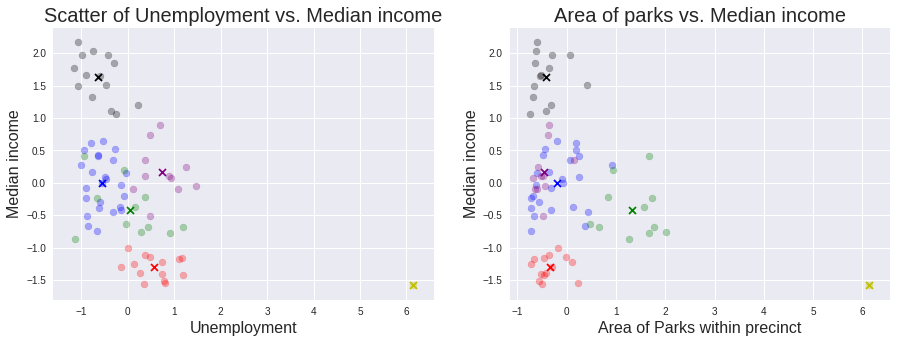

In [122]:
#Code adapted from hint notebook preprocessinANDclustering.ipynb

colors = ['r','b','y','k','g', 'purple']

fig = pl.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter(vals['unemployment'][km.labels_ == i], vals['medianincome'][km.labels_ == i], 
               color=colors[i], alpha=0.3)
    ax.scatter(c[2], c[0], color=colors[i], marker='x')
pl.xlabel('Unemployment', fontsize = 16)
pl.ylabel('Median income', fontsize = 16)
pl.title("Scatter of Unemployment vs. Median income", fontsize = 20);

ax = fig.add_subplot(122)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter(vals['green'][km.labels_ == i], vals['medianincome'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[1], c[0],  color=colors[i], marker='x')

pl.xlabel('Area of Parks within precinct', fontsize = 16)
pl.ylabel('Median income', fontsize = 16)
pl.title("Area of parks vs. Median income", fontsize = 20);


pl.show()

### **Figure 10:** Scatter of clusters determined from socio-economic variabels

There are clear clustering patterns observed from scatters of unemployment and areas of parks plotted against Median income.

There is a large cluster of high income precincts with low areas of parks within precinct and low unemployment (the cluster shaded black/grey).

For middle income precincts, there is some patterning within the clusters, although it may be appropriate to combine them based on inspection of the Unemployment variable. The clusters appear to have formed off accessibility to parks, the purple cluster has lowest access, blue cluster had medium access and green cluster appropriatey has the highest access (aside from the outlier yellow cluster). 


The red cluster indicates precincts with lowest median income, highest unemployment (again, aside from the outlier yellow cluster) and lower access to parks. Cluster centres appears to be a good fit, particularly for the parks.



In [123]:
precShpSocioNorm.head()

precinct    shape_leng    shape_area  \
0         1  80586.154615  4.730176e+07   
1         5  18676.124259  1.808880e+07   
2         6  27182.610113  2.213193e+07   
3         7  17301.308682  1.836402e+07   
4         9  19773.233410  2.139423e+07   

                                            geometry  cluster  medianincome  \
0  (POLYGON ((-74.0438776157395 40.69018767637665...      1.0      1.780387   
1  POLYGON ((-73.98863862848766 40.72293372026369...      0.0      1.104511   
2  POLYGON ((-73.99968392160721 40.73855224865976...      1.0      1.657722   
3  POLYGON ((-73.97345389423181 40.718962954076, ...      1.0     -0.372331   
4  POLYGON ((-73.97160900246391 40.72672340116989...      1.0      0.650452   

      green  unemployment  burglary  felonyassault  glarceny  glmotorvehicle  \
0 -0.359130     -1.164498 -0.424089      -0.934032  1.813476       -0.978541   
1 -0.426237     -0.371678 -1.093275      -0.770976  0.070002       -1.264748   
2 -0.526514     -0.891418 -0.548486      -0.874772  1.319700       -0.973338   
3  0.128522     -0.171050 -1.428970      -0.811832 -0.591007       -1.037675   
4 -0.197961     -0.531298 -0.381300      -0.528784  0.547549       -0.913731   

     murder      rape   robbery  felonyTotal  socioCluster  
0 -1.004290 -0.990136 -1.109600     0.445635             3  
1 -0.854715 -1.074262 -0.966673    -0.800127             3  
2 -0.961555 -0.920032 -0.613488     0.223142             3  
3 -0.726508 -0.821885 -0.799727    -1.221885             1  
4 -0.779928 -0.443320 -0.553640    -0.134250             1

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


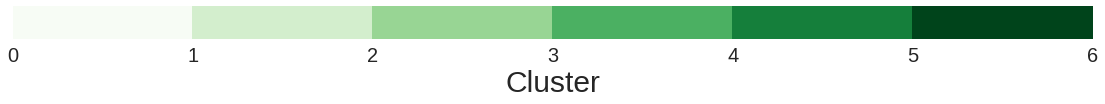

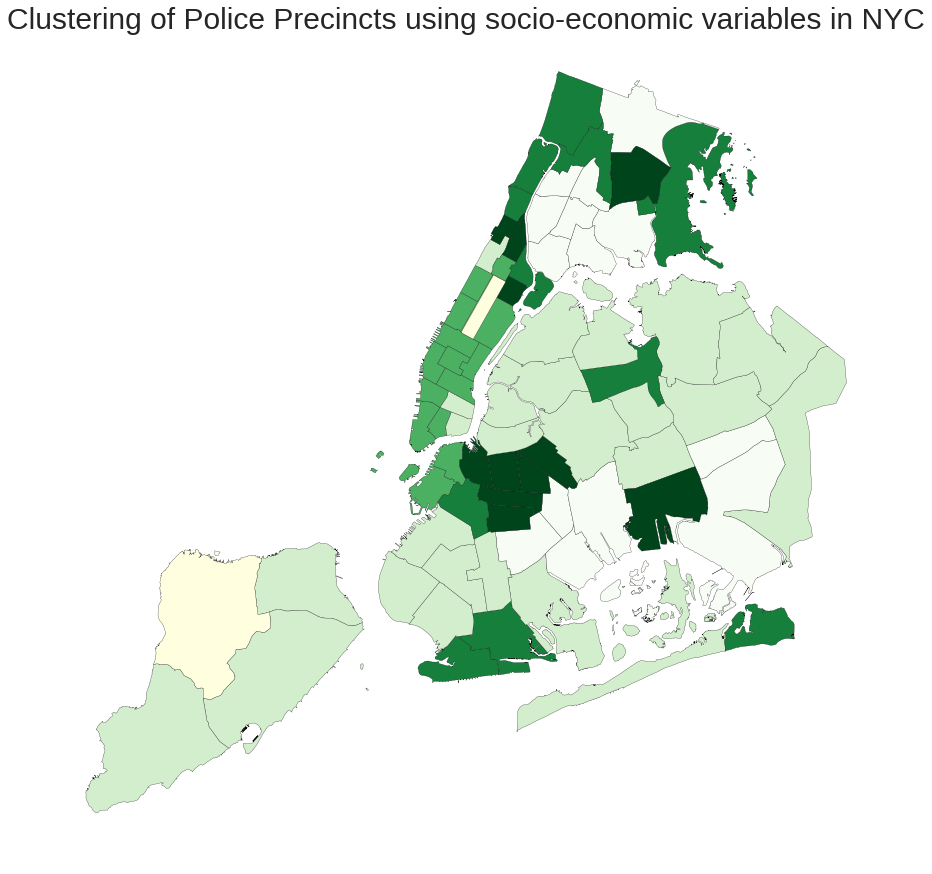

In [124]:
# Plot clusters of socioeconomic variables
## Code adapted from Homework 11 - cheers!

fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.Greens
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar. 
bounds = range(nc + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
cb3.set_label('Cluster', fontsize=30)
font_size = 20 # Adjust as appropriate.
cb3.ax.tick_params(labelsize=font_size)
ax = pl.figure(figsize=(15, 15)).add_subplot(111)
precShpSocioNorm.plot(column='socioCluster', colormap='Greens', 
                edgecolor='black', lw = .25, alpha=1, axes=ax)
MissingPrec.plot(axes = ax, color = 'LightYellow',
                 edgecolor = 'black', lw = .25);
Prec22.plot(axes = ax, color = 'LightYellow',
                 edgecolor = 'black', lw = .25);
pl.title("Clustering of Police Precincts using socio-economic variables in NYC", fontsize = 30);
tmp = ax.axis('off')

### **Figure 11:** Choropleth of police precinct clusters based on socio-economic variables

The choropleth shows five (5) clusters of socio-economic variables. Recall fitted the clustering model with six (6) clusters originally. One of these fell out as it's own cluster, and this is the Central Park precinct.

The lightest color shows the cluster aligned to areas with lowest income, higher unemployment and lower access to parks (it is the red cluster in the scatter plots above). Spatially, this is in the west parts of Brooklyn, South Queens and the Bronx.

The next lightest color aligns with the blue cluster in our scatter plot. Geographically this includes Staten Island, parts of Brooklyn and most of Queens. They had medium level income, and moderate to low access to unemployment and parks.

The parts of Manhattan spanning lower island up to the top of Central Park are the grey/black cluster from the scatter plots. They are the higher income precincts with low unemployment and interestingly still low access to parks, even though Central park is nearby. This is likely because Central Park forms its own precinct.

The next two clusters are the least spatially prevalent, with some common characteristics across uptown and northern parts of the Bronx. These are clustered with similar groups near Downtown Brooklyn and in Southern Brooklyn also. 

Reviewing the spatial patterns and knowledge that these are the green and purple clusters from our scatter plots earlier, there is a reasonable argument to combine these clusters in future. Although the green cluster does appear to have significantly better access to parkland, and it might not be these two clusters which combine if we reduce the number of clusters.




### Clustering on both Socio-economic and Crime variables 

In [125]:
## Create new df with both Crime and Socio-economic variables included
vals = precShpSocioNorm[normColsUpd]

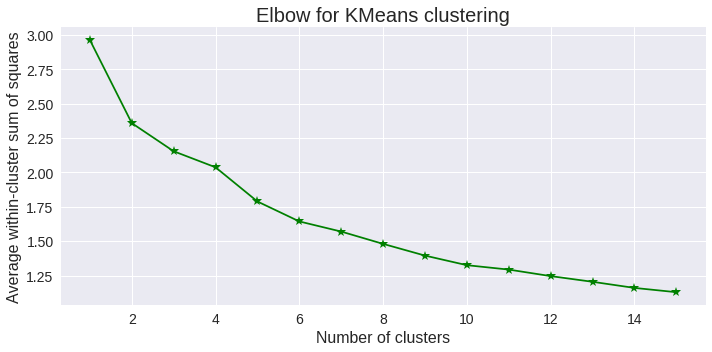

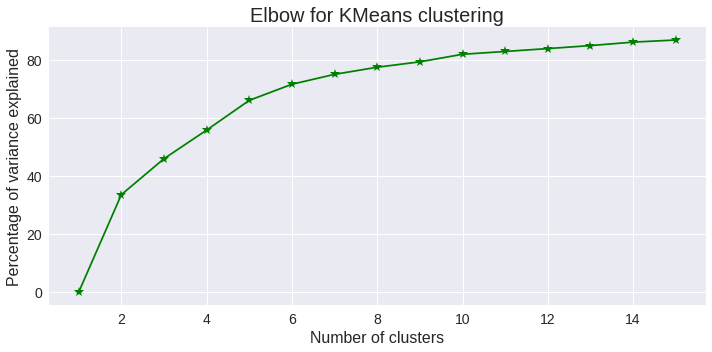

In [126]:
elbow(vals, range(1,16))

### **Figure 12:** Elbow plots for K-means clusters for cluster choice between 1 and 15

Similarly to before assess elbow plots for choice of number of clusters. Adding in the additional variables means it is more difficult to fit with the same number of clusters (we have new metrics adding additional Euclidean distance).

Five (5) clusters seems about the right about to explain as much of the variance as we can with the given factors. The marginal improvement in explanatory power for adding additional clusters starts to diminish with above five clusters.

**Choose five (5) clusters**

In [127]:
###############################################################################
# Fit K-means algorithm for selected number of clusters (again)
## Adapted code from PUI Homework 11 to fit K-means with five (5) clusters

nc = 5

km = KMeans(n_clusters=nc, random_state=888)

km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=888, tol=0.0001,
    verbose=0)

In [128]:
for j in range(nc):
    print("Precincts in cluster", j)
    print(list(precShpSocioNorm.precinct[km.labels_ == j]))
    print("\n")

precShpSocioNorm['socCrimCluster'] = km.labels_

Precincts in cluster 0
[32, 40, 42, 43, 44, 46, 47, 48, 52, 67, 70, 71, 73, 75, 77, 79, 81, 83, 103, 113]


Precincts in cluster 1
[5, 7, 9, 10, 17, 20, 23, 24, 25, 26, 28, 30, 33, 50, 68, 76, 78, 84, 88, 94, 100, 101, 111, 112, 122, 123]


Precincts in cluster 2
[1, 6, 13, 14, 18, 19]


Precincts in cluster 3
[34, 41, 45, 49, 60, 61, 62, 63, 66, 69, 72, 90, 102, 104, 105, 106, 107, 108, 109, 110, 114, 115, 120]


Precincts in cluster 4
[22]




## Plotting of scatter diagrams - Approach

Lets inspect more scatter plots with the new variable included for clustering. We'll see how this changes our results or what interesting observations we can make about the relationship between crime and socio-economic variables by precint.

Whilst we are interested in each of the seven (7) crime types and how they vary by precinct, lets plot each of the three socio-economic variables against total crime.

Lets also compare if there is a difference in relationship between socio-economic variables and a serious crime (such as murder), compared with less serious crime (such as theft of a motor vehicle).



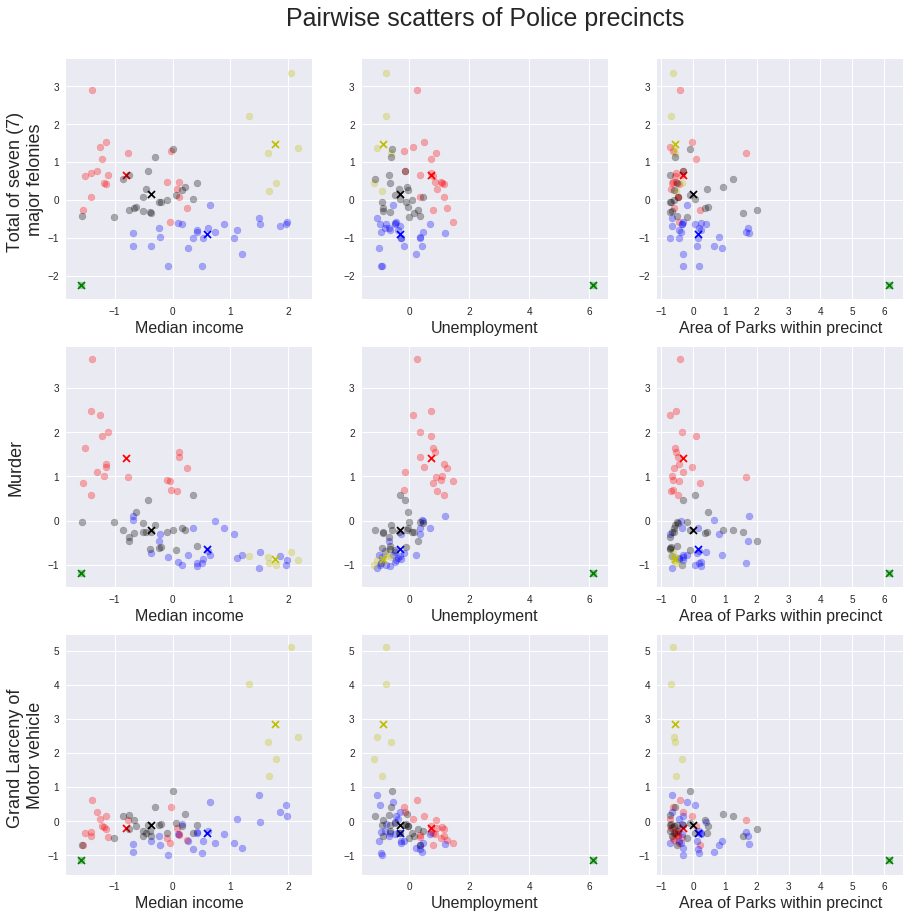

In [129]:
#Code adapted from hint notebook preprocessinANDclustering.ipynb

colors = ['r','b','y','k','g', 'purple']

fig = pl.figure(figsize=(15, 15))

ax = fig.add_subplot(331)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter( vals['medianincome'][km.labels_ == i], vals['felonyTotal'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[0], c[10], color=colors[i], marker='x')
pl.xlabel('Median income', fontsize = 16)
pl.ylabel('Total of seven (7) \nmajor felonies', fontsize = 18)
#pl.title("Scatter of Police precincts", fontsize = 20);

ax = fig.add_subplot(332)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter(vals['unemployment'][km.labels_ == i], vals['felonyTotal'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[2], c[10],  color=colors[i], marker='x')

pl.xlabel('Unemployment', fontsize = 16)
#pl.ylabel('Total of seven (7) major felonies', fontsize = 16)
pl.title("Pairwise scatters of Police precincts\n", fontsize = 25);


ax = fig.add_subplot(333)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter(vals['green'][km.labels_ == i], vals['felonyTotal'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[1], c[10],  color=colors[i], marker='x')

pl.xlabel('Area of Parks within precinct', fontsize = 16)
#pl.ylabel('Total of seven (7) major felonies', fontsize = 16)
#pl.title("Scatter of Police precincts", fontsize = 20);


ax = fig.add_subplot(334)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter( vals['medianincome'][km.labels_ == i], vals['murder'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[0], c[7], color=colors[i], marker='x')
pl.xlabel('Median income', fontsize = 16)
pl.ylabel('Murder\n', fontsize = 18)
#pl.title("Scatter of Police precincts", fontsize = 20);

ax = fig.add_subplot(335)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter(vals['unemployment'][km.labels_ == i], vals['murder'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[2], c[7],  color=colors[i], marker='x')

pl.xlabel('Unemployment', fontsize = 16)
#pl.ylabel('Total of seven (7) major felonies', fontsize = 16)
#pl.title("Scatters of Police precincts\n", fontsize = 25);


ax = fig.add_subplot(336)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter(vals['green'][km.labels_ == i], vals['murder'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[1], c[7],  color=colors[i], marker='x')

pl.xlabel('Area of Parks within precinct', fontsize = 16)
#pl.ylabel('Total of seven (7) major felonies', fontsize = 16)
#pl.title("Scatter of Police precincts", fontsize = 20);


ax = fig.add_subplot(337)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter( vals['medianincome'][km.labels_ == i], vals['glarceny'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[0], c[5], color=colors[i], marker='x')
pl.xlabel('Median income', fontsize = 16)
pl.ylabel('Grand Larceny of \nMotor vehicle', fontsize = 18)
#pl.title("Scatter of Police precincts", fontsize = 20);

ax = fig.add_subplot(338)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter(vals['unemployment'][km.labels_ == i], vals['glarceny'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[2], c[5],  color=colors[i], marker='x')

pl.xlabel('Unemployment', fontsize = 16)
#pl.ylabel('Total of seven (7) major felonies', fontsize = 16)
#pl.title("Scatters of Police precincts\n", fontsize = 25);


ax = fig.add_subplot(339)
for i,c in enumerate(km.cluster_centers_):
    ax.scatter(vals['green'][km.labels_ == i], vals['glarceny'][km.labels_ == i],
               color=colors[i], alpha=0.3)
    ax.scatter(c[1], c[5],  color=colors[i], marker='x')

pl.xlabel('Area of Parks within precinct', fontsize = 16)
#pl.ylabel('Total of seven (7) major felonies', fontsize = 16)
#pl.title("Scatter of Police precincts", fontsize = 20);


pl.show()

### **Figure 13:** Pairwise plots of precinct socio-economic and crime variables

We compiled pairwise plots of crime variables and to assess how they vary with respect to independent socio-economic variables. Overall the clusters appear to provide some explanation of crime by precinct.

Median income appears to be the best explanatory variables to understand crime at a total level (total of the major felonies). We observe good variance in the observations across crime and median income and there do appear to be some clustering patterns.

Again, Precinct 22 (Central Park) drops out into it's own cluster (and we'll remove this when plotting spatially).

We hypothesised there might be a difference in crime types by precinct, and inspecting the clusters for the Grand larcency of motor vehicle against median income, the higher income clusters are strangley more likely to commit grand larceny of a motor vehicle. This may be because higher income precincts have better and more expensive motor vehicles, so it makes more sense to steal a vehicle from one of these precincts (if you're planning on stealing a motor vehicle that is).

Comparing this with the results for murder, wealthier precincts are less likely to commit murder. Again, this seems logical from a 'rationale' standpoint. Lower income precincts have higher murder rates.

There aren't great patterns to report on in the Unemployment or Parks variables, the clustering does fit well (as expected), but not major explanatory power or variation from those two variables (apart from Central Park obviously).

**Let's plot this spatially.**

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


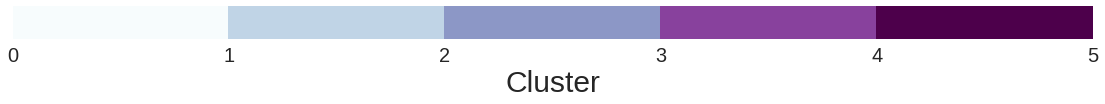

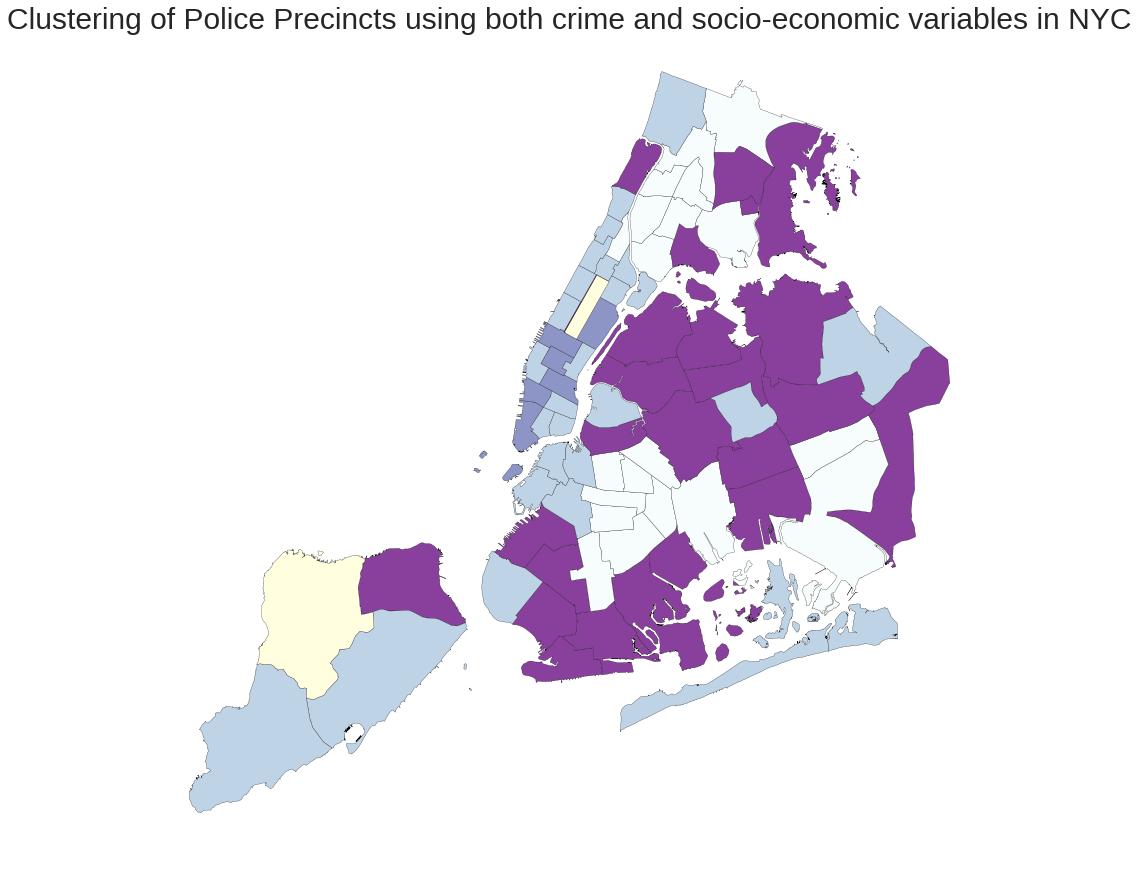

In [130]:
# Plot clusters of socioeconomic variables
## Code adapted from Homework 11 - cheers!

fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.BuPu
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map
# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar. 
bounds = range(nc + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(
    ax1,
    cmap=cmap,
    norm=norm,
    ticks=bounds,
    spacing='uniform',
    orientation='horizontal')
cb3.set_label('Cluster', fontsize=30)
font_size = 20 # Adjust as appropriate.
cb3.ax.tick_params(labelsize=font_size)
ax = pl.figure(figsize=(15, 15)).add_subplot(111)
precShpSocioNorm.plot(column='socCrimCluster', colormap='BuPu', 
                edgecolor='black', lw = .25, alpha=1, axes=ax)
MissingPrec.plot(axes = ax, color = 'LightYellow',
                 edgecolor = 'black', lw = .25);
Prec22.plot(axes = ax, color = 'LightYellow',
                edgecolor = 'black', lw = .25);
pl.title("Clustering of Police Precincts using both crime and"\
         + " socio-economic variables in NYC", fontsize = 30);
tmp = ax.axis('off')

### **Figure 14:** Choropleth of police precinct clusters based on crime and socio-economic variables

The choropleth shows four (4) clusters of crime and socio-economic variables. 

Originally we fitted five (5) clusters, however one of these fell out as Central Park, identified in yellow as an outlier.

Overall some interesting spatial patterns observed in lower income precincts such as parts of the Bronx and outer Brooklyn which it looks like exhibit similar rates and types of crime.

Parts of Queens and Brooklyn (around Downtown and south of Prospect Park) also form a cluster, paired with a few northern parts of the Bronx and one of the precincts on Staten Island.

Manhattan divides broadly into two clusters. There are higher crime rates around Midtown, meaning the previously single clustered (based only on socio-economic variables), divides into precincts which may have a lot of foot traffic during the day (e.g. because they are central working districts), and lower level of residents, income, employment and/or access to park space.


**Lets compare the choropleths side-by-side**

We can assess if there are any large changes in the clusters which develop.


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


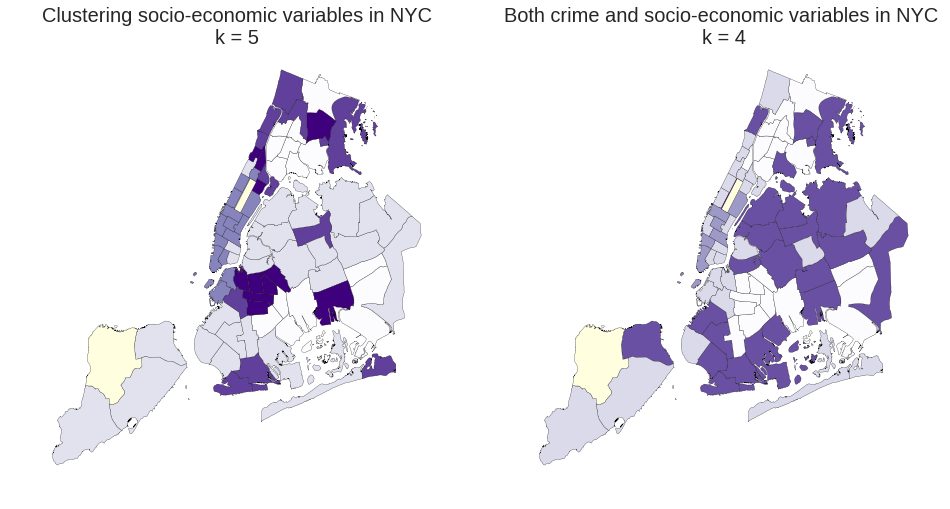

In [131]:
#f, ax = plt.subplots(figsize=(9, 9))
f = pl.figure(figsize=(16, 8))
ax = f.add_subplot(121)
precShpSocioNorm.plot(column='socioCluster', colormap='Purples', 
                edgecolor='black', lw = .25, alpha=1, axes=ax)
MissingPrec.plot(axes = ax, color = 'LightYellow',
                 edgecolor = 'black', lw = .25);
Prec22.plot(axes = ax, color = 'LightYellow',
                 edgecolor = 'black', lw = .25);
pl.title("Clustering socio-economic variables in NYC\nk = 5", fontsize = 20);
ax.set_axis_off()

ax = f.add_subplot(122)
precShpSocioNorm.plot(column='socCrimCluster', colormap='Purples', 
                edgecolor='black', lw = .25, alpha=1, axes=ax)
MissingPrec.plot(axes = ax, color = 'LightYellow',
                 edgecolor = 'black', lw = .25);
Prec22.plot(axes = ax, color = 'LightYellow',
                edgecolor = 'black', lw = .25);
pl.title("Both crime and socio-economic"\
         + " variables in NYC \nk = 4", fontsize = 20);
ax.set_axis_off()


### **Figure 15:** Panel choropleths to compare changes in clusters

The plots above can be used to assess changes in clusters. 

*Note: the colors aren't exactly comparable as the number of clusters fitted is different, but the groupings are comparable.*

The Dark purple on the right-hand-side plot which clusters most of Queens is comparable to the light purple on the left-hand side which also clusters most of Queens. There are a couple of precincts in this grouping which switch clusters, for example the precincts identified with the very dark purple on the left-hand-side.

You can also observe there was a very consistent pattern for Manhattan with pretty much a single cluster  fitted with only the socio-economic variables included. However when adding the crime data, this splits into two distinct groupings.

One of the precincts on Staten Island also switches when we introduce the crime variables, and reduce the number of clusters.

And in the Bronx, we see a fairly consistent pattern with clusters indicated in white or the darker purple. A couple of the precincts switched from one cluster to another in the Bronx with the addition of crime variables.


##  <font color=Maroon> 2.7 At last, create a function that for a target variable input generates a model based on median income (medianincome), green area (green), and unemployed fraction (unemployment), and returns some parameter of model quality and the most important feature in the model. The function should also print or otherwise report whether the feature is statistically significant. Run this function four times to predict BURGLARY, RAPE, MURDER, and TOTAL CRIME</font>


**Discuss explicitly which features are important to predict what** 

In [132]:
dfCrimeRegress = precShpSocioNorm[normColsUpd]
dfCrimeRegress.head()

medianincome     green  unemployment  burglary  felonyassault  glarceny  \
0      1.780387 -0.359130     -1.164498 -0.424089      -0.934032  1.813476   
1      1.104511 -0.426237     -0.371678 -1.093275      -0.770976  0.070002   
2      1.657722 -0.526514     -0.891418 -0.548486      -0.874772  1.319700   
3     -0.372331  0.128522     -0.171050 -1.428970      -0.811832 -0.591007   
4      0.650452 -0.197961     -0.531298 -0.381300      -0.528784  0.547549   

   glmotorvehicle    murder      rape   robbery  felonyTotal  
0       -0.978541 -1.004290 -0.990136 -1.109600     0.445635  
1       -1.264748 -0.854715 -1.074262 -0.966673    -0.800127  
2       -0.973338 -0.961555 -0.920032 -0.613488     0.223142  
3       -1.037675 -0.726508 -0.821885 -0.799727    -1.221885  
4       -0.913731 -0.779928 -0.443320 -0.553640    -0.134250

### Define function
    fitCrime()
As below. See notes for explanation of inputs and what analysis the model performs.

In [133]:
def fitCrime(yColumnName='felonyTotal', data=dfCrimeRegress, signif=0.05):
    '''Fit a multiple linear regression to the crime dataset 
    (or any other dataset) with columns 'medianincome', 
    'green', and 'unemployment'.
    
    The model fits dependent variable 'yColumnName' (Crime) 
    which is a specified column in the dataframe 'data'
    
    For further details, please reach out to Anonymous via
    email jlk635 at nyu.edu.
    
    Arguments:
    yColumnName : input as a string, this is the name of 
    column of dependent variable for regression (commonly 
    known as the y-variable), and will be used to input 
    crime variables for regression
    
    data : input dataframe which must include columns 
    'medianincome', 'green', and 'unemployment', along with
    the yColumnName column.
    
    signif : Significance level (typically known as alpha) of
    hypothesis test to assess whether the best regressor is
    statistically significant.
    '''
    import statsmodels.api as sm
    
    
    xVars = ['medianincome', 'green', 'unemployment']
    X = data[xVars]
    y = data[yColumnName]

    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model

    # Print out the statistics
    Rsqu = round(model.rsquared,4)
    mostImppt = argmax(abs(model.tvalues))
    mostImpptPval = round(min(model.pvalues),4)
    
    if mostImpptPval <= signif:
        sigTest = 'is'
    else:
        sigTest = 'is not'
      
    print("Fit {}".format(yColumnName) + ", model has R^2: {}."
          .format(Rsqu) + " Best regressor is {} ".format(mostImppt)
          + "which {}".format(sigTest) + " significant with alpha = {}"
          .format(signif)
         )

    return 
    
    

In [134]:
## Test the function for Grand Larceny
fitCrime('glarceny')

Fit glarceny, model has R^2: 0.274. Best regressor is medianincome which is significant with alpha = 0.05


#### Lets assess fit across all crimes. 

The function performs a hypothesis test to determine if the best explanatory variable in the model out of 'medianincome', 'green', or 'unemployment' is statistically significant.

**Stating the Null Hypothesis:** The most explanatory regressor (out of *'medianincome', 'green', or 'unemployment'*) has coefficient not different from (i.e. equal to) zero. 

This implies each of the regressors on their own are poor regressors, because we are testing whether the 'best regressor' is poor. And by definition if the best one is poor, then the others can not be good.

$H_0$: $\beta_{regressor}$ = $0$

$H_A$: $\beta_{regressor}$ $\neq$ $0$

$\alpha=0.1$

In [135]:
normCrimeCols = ['burglary', 'felonyassault', 'glarceny', 
                 'glmotorvehicle', 'murder', 'rape', 'robbery', 
                 'felonyTotal']

In [136]:
## Run function for all the crimes and total
for i in normCrimeCols:
    fitCrime(i, signif = 0.1)

Fit burglary, model has R^2: 0.2239. Best regressor is medianincome which is significant with alpha = 0.1
Fit felonyassault, model has R^2: 0.5746. Best regressor is medianincome which is significant with alpha = 0.1
Fit glarceny, model has R^2: 0.274. Best regressor is medianincome which is significant with alpha = 0.1
Fit glmotorvehicle, model has R^2: 0.3672. Best regressor is medianincome which is significant with alpha = 0.1
Fit murder, model has R^2: 0.5731. Best regressor is medianincome which is significant with alpha = 0.1
Fit rape, model has R^2: 0.5157. Best regressor is medianincome which is significant with alpha = 0.1
Fit robbery, model has R^2: 0.463. Best regressor is medianincome which is significant with alpha = 0.1
Fit felonyTotal, model has R^2: 0.1647. Best regressor is green which is significant with alpha = 0.1


## Discussion

We built a function which fits a multiple linear regression model to crime by precinct to obtain a regression fit using three socio-economic variables in Median Income, Unemployment, and Green area in the precinct.

The function reports model fit via R-squared and outputs the best regressor, along with if this variable is significant or not at the stated significance level.

We used the function to fit across each of the different crime types for all precincts.

Most of the R-squared values ranged between 0.2 and 0.6 overall. The exception to this was when fitting felonyTotal, the Total of all of the seven (7) major felonies which reported an R-squared of 0.1647.

For each of the Crimes modelled by themselves, Median Income was both the most explanatory and most significant variable ($\alpha$ = $0.1$) in all of the models.

For the felonyTotal model, the best regressor was Green area in the precinct. Whilst the model wasn't as good a fit overall, the *'green'* regressor was still significant ($\alpha$ = $0.1$) in the model.

One area we might look at in future is any correlation amongst the regressors. For example is there correlation between Green area per precinct, and Median Income within the precinct.

The crime types varied a lot by precinct, for example in low income areas; murder and felony assault were the more common crimes; whereas in higher income precincts, it was more common to report a theft of motor vehicle.

Income would be a good predictor for each of these types of crimes, because the occurence of the crime would either have a high positive or negative correlation to Income in these cases. Compare this with green area, well you could argue it is evenly distributed across precincts, and so we get a blend of the high and low income areas having similar access to parks, but different rates of crime type. And considering murder is way less common than having someone steal your car, the Grand Larceny involving motor vehicle makes up a high proportion of each of the precincts total for the seven (7) felonies.

Overall... **Parks**..  a good / significant predictor for crime.




## Thank you very much for a great semester!

#  <font color=Maroon>Extra Credit  </font>

I decided to add this as the conversation kept getting pushed toward details of spatial joins during the final reviews. If this all was easy, recreate the percentage of green area in a precinct, the unemployment rate by precinct, and the median income by precinct.

you will need:
a shapefile for the NYC parks which you can access from the https://data.cityofnewyork.us/. With the overlay function get the area of the green spaces contained in a precinct. 
I only selectted the following park subcategories. 

selectedParks = ['Community Park', 'Recreation Field/Courts', 'Triangle/Plaza',
       'Garden', 'Neighborhood Park', 'Nature Area', 'Waterfront Facility',
       'Historic House Park', 'Playground', 
       'Flagship Park', 
       'Jointly Operated Playground', 'Managed Sites']


A census tract shapefile is also accessible through the NYC open data portal or http://www1.nyc.gov/site/planning/data-maps/open-data.page
    
Overlay the census tract and precinct geometries (geopandas.overlay) to get the fraction of each tract in a precinct. This will allow you to create a weighted average of the unemployment percentage and median income.

You will need tree features from the American Community Survey which you can find on American Fact Finder.   
If, as they should, these are accessed through the API your API link should begin with https://api.census.gov/ (e.g. [5 year ACS](https://www.census.gov/data/developers/data-sets/acs-5year.html))

- the 2015  5 year ACS survey unemployment data by census tract (the total number of individuals is available through the API at the census tract geometry aggregation level. 

- the 2015  5 year ACS survey total count of people by census tract (to generate the unemployment percentage).

- the 2015  5 year ACS survey median income by census tract.

Some precinct geometries will fail, and likely will report that the operation is not doable with MultiPolygons. These operations are actually doable with MultyPolygons, but some of the precincts have non valid geometries. For those you can use the convex hull (pctshp.geometry.map(lambda x: x.convex_hull)) to get the intersection, with some loss (is the loss in accuracy or precision?)